<a href="https://colab.research.google.com/github/JT-street53/DataScienceHillClimb_KKBox/blob/master/KKBOX_LightGBM%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Setups

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install optuna

# Overview
##### 1. Preparation
1.1   Load Datasets<br>
->   Loading all datasets and conducting a Reduce Memory Usage function. <br>
1.2   Company Information<br>
->   Working through basic company information<br>
1.3   Problem Establishment<br>
->   Through some data analysis, we establish our approach for "preventing KKBOX users from slipping away from service."<br>
##### 2. Building the Machine Learning Model
2.1   Problem Definition<br>
2.2   Feature Engineering<br>
2.3   Machine Learning<br>

## Basic Settings

In [0]:
import numpy as np
import pandas as pd
import scipy as sp
import pickle, gc, warnings, os, heapq, optuna, scipy

import datetime as dt

import seaborn as sns
from matplotlib import pyplot as plt
% matplotlib inline

from collections import Counter
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

import lightgbm as lgb

warnings.filterwarnings('ignore')

In [0]:
VERSION = "kkbox_LL_201"
PATH = "./drive/My Drive/DataScienceHillClimb/ALBERT/input"
PICKLE_PATH = "./drive/My Drive/DataScienceHillClimb/ALBERT/input/pickle"
MODEL_PATH = './drive/My Drive/DataScienceHillClimb/ALBERT/input/models'
READ = True
WRITE = False
SEED = 1234
N_SPLITS = 5
PERMUTATION_CALC = False
BAYES_OPT_CALC = False
CALC_ML_MODEL = True
CALC_DL_MODEL = True
os.listdir(PATH)

['members.csv.gz',
 'transactions.csv.gz',
 'user_logs.csv.gz',
 'train_test.csv.gz',
 'train.csv.gz',
 'test.csv.gz',
 'test_answers.pickle',
 'train_answers.pickle',
 'members_target.csv.gz',
 'user_logs_target.csv.gz',
 'user_log_3months.csv.gz',
 'ProblemEstablishment002.png',
 'f_score.png',
 'pickle',
 'models',
 'train_test_101.csv.gz',
 'train_101.csv.gz',
 'test_101.csv.gz',
 'test_answers_101.pickle',
 'train_answers_101.pickle',
 'members_target_101.csv.gz',
 'user_logs_target_101.csv.gz',
 'user_log_3months_101.csv.gz',
 'test_answers_201.pickle',
 'train_answers_201.pickle',
 'train_test_201.csv.gz',
 'train_201.csv.gz',
 'test_201.csv.gz',
 'members_target_201.csv.gz',
 'user_logs_target_201.csv.gz',
 'user_log_3months_201.csv.gz']

# 1. Preparation

## 1.1 Load Datasets

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
%%time
if WRITE:
    df_user_logs = pd.read_csv(PATH+'/user_logs.csv.gz', compression='gzip')
    df_user_logs = reduce_mem_usage(df_user_logs)

Mem. usage decreased to 2388.03 Mb (52.8% reduction)
CPU times: user 2min 1s, sys: 9.41 s, total: 2min 11s
Wall time: 2min 11s


In [0]:
%%time
if WRITE:
    df_members = pd.read_csv(PATH+'/members.csv.gz', compression='gzip')
    df_members = reduce_mem_usage(df_members)

Mem. usage decreased to 25.63 Mb (41.7% reduction)
CPU times: user 1.86 s, sys: 62 ms, total: 1.92 s
Wall time: 3.09 s


In [0]:
%%time
if WRITE:
    df_transactions = pd.read_csv(PATH+'/transactions.csv.gz', compression='gzip')
    df_transactions = reduce_mem_usage(df_transactions)

Mem. usage decreased to 104.43 Mb (54.2% reduction)
CPU times: user 5.84 s, sys: 114 ms, total: 5.96 s
Wall time: 6.54 s


## 1.2 Company Information

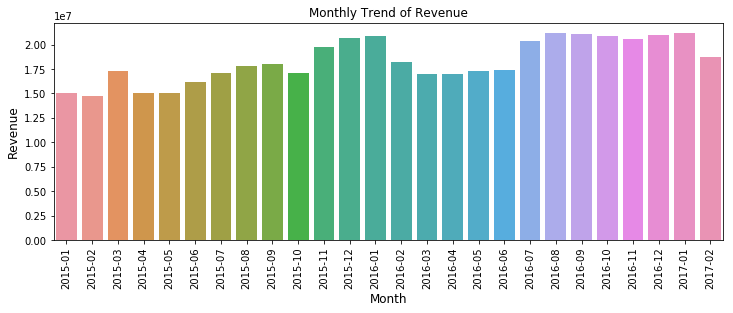

In [0]:
if WRITE:
    df_transactions["DT_M_EXP"] = (pd.DatetimeIndex(df_transactions['membership_expire_date']).year - 2015)*12 + pd.DatetimeIndex(df_transactions['membership_expire_date']).month
    df_transactions["DT_M"] = (pd.DatetimeIndex(df_transactions['transaction_date']).year - 2015)*12 + pd.DatetimeIndex(df_transactions['transaction_date']).month
    df_transactions["transaction_date_ym"] = df_transactions['transaction_date'].apply(lambda x: x[:-3])

    # monthly revenue trend
    monthly_revenue=df_transactions.groupby("transaction_date_ym").actual_amount_paid.sum()
    plt.figure(figsize=(12,4))
    sns.barplot(monthly_revenue.index, monthly_revenue,order=monthly_revenue.index)
    plt.ylabel('Revenue', fontsize=12)
    plt.xlabel('Month', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Monthly Trend of Revenue", fontsize=12)
    plt.show()

Here, we can see how there is a very gradual growth of revenue within this 2 years. 

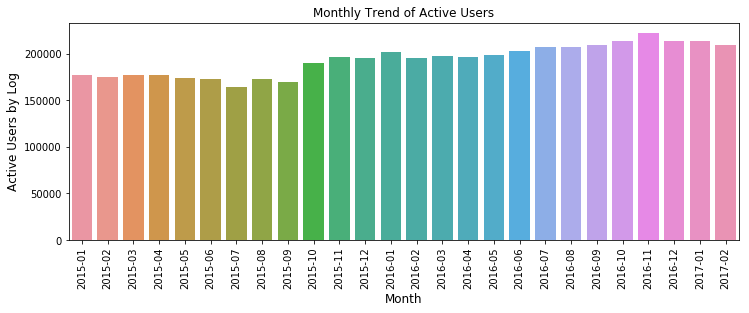

In [0]:
if WRITE:
    df_user_logs["date_ym"] = df_user_logs['date'].apply(lambda x: x[:-3])
    
    # monthly user log trend
    monthly_users=df_user_logs.groupby("date_ym").msno.nunique()
    plt.figure(figsize=(12,4))
    sns.barplot(monthly_users.index, monthly_users, order=monthly_users.index)
    plt.ylabel('Active Users by Log', fontsize=12)
    plt.xlabel('Month', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Monthly Trend of Active Users", fontsize=12)
    plt.show()

## 1.3 Problem Establishment
We establish the goal of this project together with the problem we claim to solve here. <br>
First, we exclude transaction records that aren't in either user_log.csv or members.csv

In [0]:
# exclude msno user IDs that don't have records for either csvs
if WRITE:
    df_user_log_msno = pd.DataFrame(df_user_logs.msno.unique(), columns=["msno"])
    df_transactions = df_transactions.merge(df_user_log_msno, how="inner", on="msno").reset_index(drop=True)
    df_transactions = df_transactions.merge(df_members[["msno"]], how="inner", on="msno").reset_index(drop=True)
    df_transactions.info()
    display(df_transactions.head(2))
    gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2846871 entries, 0 to 2846870
Data columns (total 12 columns):
msno                      object
payment_method_id         int8
payment_plan_days         int16
plan_list_price           int16
actual_amount_paid        int16
is_auto_renew             int8
transaction_date          object
membership_expire_date    object
is_cancel                 int8
DT_M_EXP                  int64
DT_M                      int64
transaction_date_ym       object
dtypes: int16(3), int64(2), int8(3), object(4)
memory usage: 154.8+ MB


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,DT_M_EXP,DT_M,transaction_date_ym
0,++0t0Uy2D3r1pRVxg28G3r3l5PfhFlCPMGElwHqbYL8=,35,7,0,0,0,2015-06-14,2015-06-15,0,6,6,2015-06
1,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,38,30,149,149,0,2015-09-29,2015-10-29,0,10,9,2015-09


Now calculate the expired days that occured for all transactions which happend an invalidation or cancellation of the membership. Expiration is defined as follows.<br>

* is_auto_renew = 0 and duration of expired days > 0
* is_auto_renew = 1 and is_cancel = 1 and duration of expired days > 0<br>

The duration of the expired days will be calculated as follows. <br>

* subtract membership_expire_date from the next transaction_date of the same user
* If there are no "next transaction_date" available, subtract the membership_expire_date from "today" which is 2017-02-28, the last day of user_log.csv

In [0]:
if WRITE:
    df_transactions = df_transactions.sort_values(by=['msno', 'transaction_date']).reset_index(drop=True)
    df_transactions["expired_days"] = (pd.DatetimeIndex(df_transactions.groupby('msno', as_index=False).shift(-1)['transaction_date']) - pd.DatetimeIndex(df_transactions['membership_expire_date'])).days
    df_transactions["expired_days"] = df_transactions["expired_days"].apply(lambda x: x if pd.notnull(x) else np.inf)
    df_transactions["expired_till_now"] = (df_transactions.expired_days==np.inf).astype(int)
    df_transactions.loc[df_transactions.expired_days==np.inf, "expired_days"] = (pd.to_datetime("2017-02-28", format='%Y-%m-%d') - pd.DatetimeIndex(df_transactions[df_transactions.expired_days==np.inf]['membership_expire_date'])).days

    df_transactions["is_valid_now"] = (pd.DatetimeIndex(df_transactions.groupby(['msno'])['membership_expire_date'].transform(max)) > pd.to_datetime("2017-02-28", format='%Y-%m-%d')).astype(int)
    df_transactions["expired_day_exists"] = (((df_transactions.is_auto_renew==0) & (df_transactions.expired_days>0)) | (((df_transactions.is_auto_renew==1) & (df_transactions.is_cancel==1)) & (df_transactions.expired_days>0))).astype(int)

    display(df_transactions.tail())

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,DT_M_EXP,DT_M,transaction_date_ym,expired_days,expired_till_now,is_valid_now,expired_day_exists
2846866,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36,30,180,180,0,2016-11-29,2016-12-29,0,24,23,2016-11,1.0,0,1,1
2846867,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36,30,180,180,0,2016-12-30,2017-01-29,0,25,24,2016-12,2.0,0,1,1
2846868,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36,30,180,180,0,2017-01-31,2017-03-02,0,27,25,2017-01,-2.0,1,1,0
2846869,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,40,30,149,149,1,2017-02-05,2017-03-04,0,27,26,2017-02,-4.0,1,1,0
2846870,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,35,7,0,0,0,2015-06-08,2015-06-15,0,6,6,2015-06,624.0,1,0,1


80% border line : 240607 recontracts which is for less than 26 days
85% border line : 255645 recontracts which is for less than 42 days
90% border line : 270683 recontracts which is for less than 74 days
95% border line : 285721 recontracts which is for less than 156 days


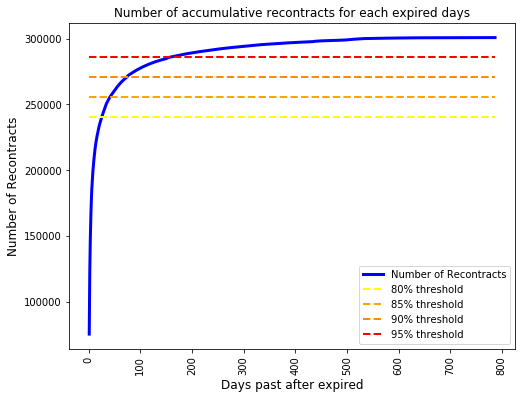

In [0]:
# the number of recontracts for each expired days
if WRITE:
    df_expired_days = pd.DataFrame(
        np.sort(np.array(df_transactions.expired_days[df_transactions.expired_days>0][df_transactions.expired_day_exists==1][df_transactions.expired_till_now==0])).astype(int), 
        columns=["Number of Recontracts"]
    )
    exp_days_cumsum = pd.DataFrame(np.cumsum(df_expired_days["Number of Recontracts"].value_counts().sort_index())).reset_index().rename(columns={"index":'expired days'})

    threshold_80 = int(exp_days_cumsum["Number of Recontracts"].max() * 0.8)
    threshold_days = exp_days_cumsum[exp_days_cumsum["Number of Recontracts"] > threshold_80].head(1)["expired days"].values[0]
    print(f"80% border line : {threshold_80} recontracts which is for less than {threshold_days} days")
    threshold_85 = int(exp_days_cumsum["Number of Recontracts"].max() * 0.85)
    threshold_days = exp_days_cumsum[exp_days_cumsum["Number of Recontracts"] > threshold_85].head(1)["expired days"].values[0]
    print(f"85% border line : {threshold_85} recontracts which is for less than {threshold_days} days")
    threshold_90 = int(exp_days_cumsum["Number of Recontracts"].max() * 0.9)
    threshold_days = exp_days_cumsum[exp_days_cumsum["Number of Recontracts"] > threshold_90].head(1)["expired days"].values[0]
    print(f"90% border line : {threshold_90} recontracts which is for less than {threshold_days} days")
    threshold_95 = int(exp_days_cumsum["Number of Recontracts"].max() * 0.95)
    threshold_days = exp_days_cumsum[exp_days_cumsum["Number of Recontracts"] > threshold_95].head(1)["expired days"].values[0]
    print(f"95% border line : {threshold_95} recontracts which is for less than {threshold_days} days")

    threshold_bar_80 = np.array([threshold_80 for i in range(len(exp_days_cumsum))])
    threshold_bar_85 = np.array([threshold_85 for i in range(len(exp_days_cumsum))])
    threshold_bar_90 = np.array([threshold_90 for i in range(len(exp_days_cumsum))])
    threshold_bar_95 = np.array([threshold_95 for i in range(len(exp_days_cumsum))])

    plt.figure(figsize=(8,6))

    plt.plot('expired days', 'Number of Recontracts', data=exp_days_cumsum, marker='', color='blue', linewidth=3)
    plt.plot(exp_days_cumsum["expired days"], threshold_bar_80, marker='', color='yellow', linewidth=2, linestyle='dashed', label="80% threshold")
    plt.plot(exp_days_cumsum["expired days"], threshold_bar_85, marker='', color='orange', linewidth=2, linestyle='dashed', label="85% threshold")
    plt.plot(exp_days_cumsum["expired days"], threshold_bar_90, marker='', color='darkorange', linewidth=2, linestyle='dashed', label="90% threshold")
    plt.plot(exp_days_cumsum["expired days"], threshold_bar_95, marker='', color='red', linewidth=2, linestyle='dashed', label="95% threshold")
    plt.legend()

    plt.ylabel('Number of Recontracts', fontsize=12)
    plt.xlabel('Days past after expired', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Number of accumulative recontracts for each expired days", fontsize=12)

    plt.show()

Here, we can see how the majority of recontracts have been made within 1 to 2 months after the last transaction. <br>
Let's define the word "threshold" to be the expired days in which we want to divide the transaction records so that one pile of transaction records can represent transactions which "is probable that recontracts happen", where the other pile of transaction records represent ones which "is NOT probable that recontracts happen". By doing this, building a machine learning model that predicts the two classes will become a model that predicts users that are close to moving away from the music(KKBOX) service. 

Now, putting the threshold at 26 days, where 80% of recontracts happen before that number, will be a little too early, as we can see the accumulative graph is still on it's gradually increasing phase. <br>
On the other hand, putting the threshold at 156 days, where 95% of recontracts happpen before that number, will be a little too late, since only 5% of the data will be on one class. <br>
Putting the threshold at around 74 days seems good. 

In [0]:
if WRITE:
    df = df_transactions[df_transactions.expired_days>0][df_transactions.expired_day_exists==1][df_transactions.expired_till_now==0].drop(["is_valid_now", "expired_day_exists", "expired_till_now"], axis=1).reset_index(drop=True)
    df["expired_over_74days"] = (df.expired_days >= 74).astype(int)
    df.info()
    display(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300759 entries, 0 to 300758
Data columns (total 14 columns):
msno                      300759 non-null object
payment_method_id         300759 non-null int8
payment_plan_days         300759 non-null int16
plan_list_price           300759 non-null int16
actual_amount_paid        300759 non-null int16
is_auto_renew             300759 non-null int8
transaction_date          300759 non-null object
membership_expire_date    300759 non-null object
is_cancel                 300759 non-null int8
DT_M_EXP                  300759 non-null int64
DT_M                      300759 non-null int64
transaction_date_ym       300759 non-null object
expired_days              300759 non-null float64
expired_over_74days       300759 non-null int64
dtypes: float64(1), int16(3), int64(3), int8(3), object(4)
memory usage: 20.9+ MB


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,DT_M_EXP,DT_M,transaction_date_ym,expired_days,expired_over_74days
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,38,30,149,149,0,2015-09-29,2015-10-29,0,10,9,2015-09,2.0,0
1,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,38,10,0,0,0,2015-11-30,2015-12-10,0,12,11,2015-11,2.0,0


However, I believe one aspect is missing in this analysis. Even for users that had recontracts after 74 days, they DID have a recontract. The worse users are those who has no recontracts and are expired for more than 74 days "today". <br>
We shall add these user transactions in the record as well. For easier prediction, we identify users who are expired for more than 90 days (3 months). 

In [0]:
if WRITE:
    df_expired_till_now_over74days = df_transactions[df_transactions.expired_days>=74][df_transactions.expired_day_exists==1][df_transactions.expired_till_now==1].drop(["is_valid_now", "expired_day_exists", "expired_till_now"], axis=1).reset_index(drop=True)
    df_expired_till_now_over74days["expired_over_74days"] = (df_expired_till_now_over74days.expired_days >= 74).astype(int)
    df_expired_till_now_over74days.info()
    display(df_expired_till_now_over74days.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151746 entries, 0 to 151745
Data columns (total 14 columns):
msno                      151746 non-null object
payment_method_id         151746 non-null int8
payment_plan_days         151746 non-null int16
plan_list_price           151746 non-null int16
actual_amount_paid        151746 non-null int16
is_auto_renew             151746 non-null int8
transaction_date          151746 non-null object
membership_expire_date    151746 non-null object
is_cancel                 151746 non-null int8
DT_M_EXP                  151746 non-null int64
DT_M                      151746 non-null int64
transaction_date_ym       151746 non-null object
expired_days              151746 non-null float64
expired_over_74days       151746 non-null int64
dtypes: float64(1), int16(3), int64(3), int8(3), object(4)
memory usage: 10.6+ MB


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,DT_M_EXP,DT_M,transaction_date_ym,expired_days,expired_over_74days
0,++0t0Uy2D3r1pRVxg28G3r3l5PfhFlCPMGElwHqbYL8=,35,7,0,0,0,2015-06-14,2015-06-15,0,6,6,2015-06,624.0,1
1,++4TTdpnmM24NYX7LEVvZggYMuzytn6fmmDaBzt1WB8=,35,7,0,0,0,2015-06-01,2015-06-15,0,6,6,2015-06,624.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452505 entries, 0 to 452504
Data columns (total 14 columns):
msno                      452505 non-null object
payment_method_id         452505 non-null int8
payment_plan_days         452505 non-null int16
plan_list_price           452505 non-null int16
actual_amount_paid        452505 non-null int16
is_auto_renew             452505 non-null int8
transaction_date          452505 non-null object
membership_expire_date    452505 non-null object
is_cancel                 452505 non-null int8
DT_M_EXP                  452505 non-null int64
DT_M                      452505 non-null int64
transaction_date_ym       452505 non-null object
expired_days              452505 non-null float64
expired_over_74days       452505 non-null int64
dtypes: float64(1), int16(3), int64(3), int8(3), object(4)
memory usage: 31.5+ MB


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,DT_M_EXP,DT_M,transaction_date_ym,expired_days,expired_over_74days
0,aWVRzXtkjcavcieQzNRtlw2GTZ0zU1vEDF1n9V9HdE4=,40,31,149,149,1,2015-01-02,2015-01-01,1,1,1,2015-01,3.0,0
1,SyFxwV6Moue8pJkHddKMWweSho3jkbSTLJBmCL9NRw8=,40,31,149,149,1,2015-01-02,2015-01-01,1,1,1,2015-01,5.0,0


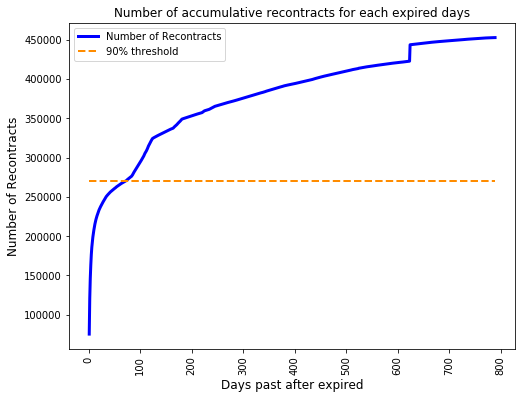

In [0]:
if WRITE:
    df_full = pd.concat([df, df_expired_till_now_over74days], axis=0, ignore_index=True)
    df_full = df_full.sort_values('membership_expire_date').reset_index(drop=True)
    df_full.info()
    display(df_full.head(2))

    # the number of recontracts for each expired days
    df_expired_days = pd.DataFrame(
        np.sort(np.array(df_full.expired_days)).astype(int), 
        columns=["Number of Recontracts"]
    )
    exp_days_cumsum = pd.DataFrame(np.cumsum(df_expired_days["Number of Recontracts"].value_counts().sort_index())).reset_index().rename(columns={"index":'expired days'})

    threshold_bar_90 = np.array([threshold_90 for i in range(len(exp_days_cumsum))])

    plt.figure(figsize=(8,6))

    plt.plot('expired days', 'Number of Recontracts', data=exp_days_cumsum, marker='', color='blue', linewidth=3)
    plt.plot(exp_days_cumsum["expired days"], threshold_bar_90, marker='', color='darkorange', linewidth=2, linestyle='dashed', label="90% threshold")
    plt.legend()

    plt.ylabel('Number of Recontracts', fontsize=12)
    plt.xlabel('Days past after expired', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Number of accumulative recontracts for each expired days", fontsize=12)

    plt.show()

There seems to be a systematic error that produces too many users who has expired days for 600 to 700. 

In [0]:
if WRITE:
    df_full[(df_full.expired_days>600) & (df_full.expired_days<700)].expired_days.value_counts()

Now, exclude the expired_days==624.0 since this seems to be an outlier. (For some reason, IDK why)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431631 entries, 0 to 431630
Data columns (total 14 columns):
msno                      431631 non-null object
payment_method_id         431631 non-null int8
payment_plan_days         431631 non-null int16
plan_list_price           431631 non-null int16
actual_amount_paid        431631 non-null int16
is_auto_renew             431631 non-null int8
transaction_date          431631 non-null object
membership_expire_date    431631 non-null object
is_cancel                 431631 non-null int8
DT_M_EXP                  431631 non-null int64
DT_M                      431631 non-null int64
transaction_date_ym       431631 non-null object
expired_days              431631 non-null float64
expired_over_74days       431631 non-null int64
dtypes: float64(1), int16(3), int64(3), int8(3), object(4)
memory usage: 30.0+ MB


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,DT_M_EXP,DT_M,transaction_date_ym,expired_days,expired_over_74days
0,aWVRzXtkjcavcieQzNRtlw2GTZ0zU1vEDF1n9V9HdE4=,40,31,149,149,1,2015-01-02,2015-01-01,1,1,1,2015-01,3.0,0
1,SyFxwV6Moue8pJkHddKMWweSho3jkbSTLJBmCL9NRw8=,40,31,149,149,1,2015-01-02,2015-01-01,1,1,1,2015-01,5.0,0


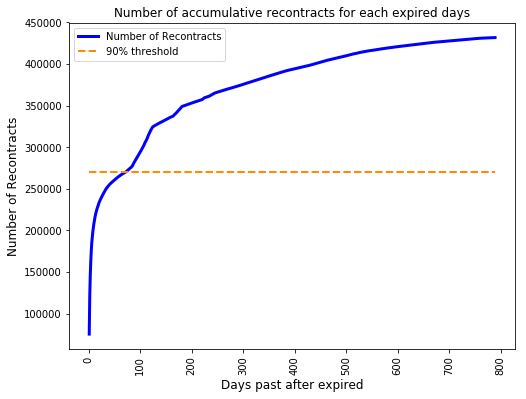

In [0]:
if WRITE:
    df_full = df_full[df_full.expired_days!=624.0].reset_index(drop=True)
    df_full.info()
    display(df_full.head(2))

    # the number of recontracts for each expired days
    df_expired_days = pd.DataFrame(
        np.sort(np.array(df_full.expired_days)).astype(int), 
        columns=["Number of Recontracts"]
    )
    exp_days_cumsum = pd.DataFrame(np.cumsum(df_expired_days["Number of Recontracts"].value_counts().sort_index())).reset_index().rename(columns={"index":'expired days'})

    threshold_bar_90 = np.array([threshold_90 for i in range(len(exp_days_cumsum))])

    plt.figure(figsize=(8,6))

    plt.plot('expired days', 'Number of Recontracts', data=exp_days_cumsum, marker='', color='blue', linewidth=3)
    plt.plot(exp_days_cumsum["expired days"], threshold_bar_90, marker='', color='darkorange', linewidth=2, linestyle='dashed', label="90% threshold")
    plt.legend()

    plt.ylabel('Number of Recontracts', fontsize=12)
    plt.xlabel('Days past after expired', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Number of accumulative recontracts for each expired days", fontsize=12)

    plt.show()

Looks very nice. <br>
<br>
Next, we want to establish a more detailed problem statement. <br>
The image bellow shows information on how our machine learning problem works. We presume that, we need to give out coupons right after or at the moment of a user's expiration, which means the inference will be conducted by a trigger of expiration. Thus, available features for the machine learning will be features that occured before expiration date. 

<img src="https://drive.google.com/uc?export=view&id=1e6bu8FWLWHArS5vpdU0Wgsf1eeXoCfwt">

For the metric, we use the f1 score. The general equation is as follows. For here, beta=1. The reason we use this metric is because we want to understand how accurately our model can predict "slip aways", and because of class imbalance, it is preferred to use the f1 score. 

<img src="https://drive.google.com/uc?export=view&id=10hL2ChYAXR78m9kKqEB2Si4qaOncQ-bx">

In [0]:
if WRITE:
    try:
        del df_user_log_msno, df_expired_days, df_expired_till_now_over74days, df, monthly_users, monthly_revenue
    except NameError:
        pass
    gc.collect()

# 2. Building the Machine Learning Model

## 2.1 Problem Definition
For evaluating the model, we will keep a test dataset to prevent overfitting. We try to build a practical evaluation method so that new future data can be correctly evaluated. <br>
Data that have transaction date on September, 2016 to March, 2017 is used for test data, and other past data for training data. 

In [0]:
if WRITE:
    df_train = df_full[(df_full.DT_M_EXP < 23)&(df_full.DT_M_EXP > 2)].reset_index(drop=True)
    df_test = df_full[(df_full.DT_M_EXP >= 23)&(df_full.DT_M_EXP < 26)].reset_index(drop=True)
    df_train["mode"] = "train"
    df_test["mode"] = "test"
    df_train_test = pd.concat([df_train, df_test]).reset_index(drop=True)
    print("Shape of df_train : ", df_train.shape)
    print("Shape of df_test : ", df_test.shape)
    print("Shape of df_train_test : ", df_train_test.shape)
    df_train_test.head(2)

Shape of df_train :  (339380, 15)
Shape of df_test :  (73494, 15)
Shape of df_train_test :  (412874, 15)


In [0]:
# delete records that aren't in dataset
if WRITE:
    start_mem = (df_members.memory_usage().sum() + df_user_logs.memory_usage().sum()) / 1024**2    
    df_user_logs = pd.merge(pd.DataFrame(df_train_test.msno.unique(), columns=["msno"]), df_user_logs).reset_index(drop=True)
    df_members = pd.merge(pd.DataFrame(df_train_test.msno.unique(), columns=["msno"]), df_members).reset_index(drop=True)
    print("Shape of df_user_logs : ", df_user_logs.shape)
    print("Shape of df_members : ", df_members.shape)
    end_mem = (df_members.memory_usage().sum() + df_user_logs.memory_usage().sum()) / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

Shape of df_user_logs :  (29671544, 10)
Shape of df_members :  (174878, 6)
Mem. usage decreased to 1193.14 Mb (59.9% reduction)


In [0]:
# write
if WRITE:
    df_train_test.to_csv(PATH+'/train_test_201.csv.gz', compression='gzip', index=False)
    df_train.to_csv(PATH+'/train_201.csv.gz', compression='gzip', index=False)
    df_test.to_csv(PATH+'/test_201.csv.gz', compression='gzip', index=False)
    df_user_logs.to_csv(PATH+'/user_logs_target_201.csv.gz', compression='gzip', index=False)
    df_members.to_csv(PATH+'/members_target_201.csv.gz', compression='gzip', index=False)
# read
if READ:
    df_train_test = reduce_mem_usage(pd.read_csv(PATH+'/train_test_201.csv.gz', compression='gzip'))
    df_train = reduce_mem_usage(pd.read_csv(PATH+'/train_201.csv.gz', compression='gzip'))
    df_user_logs = reduce_mem_usage(pd.read_csv(PATH+'/user_logs_target_201.csv.gz', compression='gzip'))
    df_members = reduce_mem_usage(pd.read_csv(PATH+'/members_target_201.csv.gz', compression='gzip'))
print("Shape of df_train : ", df_train.shape)
print("Shape of df_train_test : ", df_train_test.shape)
print("Shape of df_user_logs : ", df_user_logs.shape)
print("Shape of df_members : ", df_members.shape)
    

Mem. usage decreased to 21.26 Mb (55.0% reduction)
Mem. usage decreased to 17.48 Mb (55.0% reduction)
Mem. usage decreased to 1188.47 Mb (47.5% reduction)
Mem. usage decreased to  4.67 Mb (41.7% reduction)
Shape of df_train :  (339380, 15)
Shape of df_train_test :  (412874, 15)
Shape of df_user_logs :  (29671544, 10)
Shape of df_members :  (174878, 6)


## 2.2 Feature Engineering

### 2.2.0 Functions

In [0]:
usecols = []

In [0]:
def feature_target_relation(df, column_name, min_samples=3000, verbose=True):
    '''
    -> Find out values that have a high positive rate for the feature(column). Appliable for only categorical data. 
    df : DataFrame to apply
    columns_name : the feature(column) to apply
    min_sample : least number of samples for a certain value 
    verbose : if True, it will display the top and bottom positive ratio values for the column. 
    '''
    positive = pd.DataFrame.from_dict(df[df.expired_over_74days==1][column_name].value_counts().to_dict(), orient='index', columns=['positive']).reset_index()
    negative = pd.DataFrame.from_dict(df[df.expired_over_74days==0][column_name].value_counts().to_dict(), orient='index', columns=['negative']).reset_index()
    
    feature_target_relation = positive.merge(negative, on='index').rename(columns={'index':column_name})
    feature_target_relation['positive_ratio'] = feature_target_relation[["positive", "negative"]].apply(lambda x: x[0]/(x[1]+x[0]), axis=1)
    feature_target_relation = feature_target_relation[feature_target_relation.positive+feature_target_relation.negative > min_samples].sort_values("positive_ratio", ascending=False).reset_index(drop=True)
    if verbose:
        print("********** Length of unique values : ", len(feature_target_relation))
        print(column_name+" with high positive ratio")
        display(feature_target_relation.head(5))
        print(column_name+" with high negative ratio")
        display(feature_target_relation.sort_values("positive_ratio", ascending=True).head(5))
    return feature_target_relation

def customized_get_dummies(df, column_name, min_samples=3000):
    for c in df[column_name].unique():
        if df[df[column_name]==c].shape[0] > min_samples:
            df[column_name+"_"+str(c)] = (df[column_name] == c).astype(int)

In [0]:
def show_numerical_feature_trends(df, columns_name, bw=0.1):
    '''
    -> Show trends within positive and negative value with histogram.  Both raw and log
    df : DataFrame to apply
    columns_name : the feature(column) to apply
    bins : matplotllib bins
    '''
    sns.set()
    plt.figure(figsize=(12,4))

    sns.kdeplot(df[df.expired_over_74days==1][columns_name], bw=bw, label=columns_name+" positive", shade=True)
    sns.kdeplot(df[df.expired_over_74days==0][columns_name], bw=bw, label=columns_name+" negative", shade=True)
    plt.legend()
    plt.ylabel("Count", fontsize=12)
    plt.xlabel(columns_name, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("KDE plot for positive, negative values : "+columns_name, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,4))
    
    min_value = df[columns_name].min()
    sns.kdeplot(df[df.expired_over_74days==1][columns_name].apply(lambda x: np.log(x-min_value+1)), 
                bw=bw, label="LOG "+columns_name+" positive", shade=True)
    sns.kdeplot(df[df.expired_over_74days==0][columns_name].apply(lambda x: np.log(x-min_value+1)), 
                bw=bw, label="LOG "+columns_name+" negative", shade=True)
    plt.legend()
    plt.ylabel("Count", fontsize=12)
    plt.xlabel(columns_name, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("KDE plot for positive, negative values : LOG "+columns_name, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    

### 2.2.1 transactions.csv

In [0]:
#################### payment_method_id
#------------------------------------------------------------------
customized_get_dummies(df_train_test, "payment_method_id", min_samples=3000)
#------------------------------------------------------------------

df_payment_method_id = feature_target_relation(df_train, "payment_method_id", min_samples=3000)

def add_payment_method_id(num_features, df=df_payment_method_id, usecols=usecols, column_name="payment_method_id"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))


********** Length of unique values :  10
payment_method_id with high positive ratio


,payment_method_id,positive,negative,positive_ratio
0,41,20625,3569,0.852484
1,35,18959,5599,0.772009
2,39,3667,1961,0.651564
3,32,8055,5988,0.573595
4,37,2156,1716,0.556818


payment_method_id with high negative ratio


,payment_method_id,positive,negative,positive_ratio
9,36,9507,39077,0.195682
8,38,37213,140214,0.209737
7,29,1379,3788,0.266886
6,28,2574,6311,0.289702
5,40,6995,5826,0.545589


In [0]:
#################### payment_plan_days ... categorized
def return_closest(n, value_set):
    return min(value_set, key=lambda x:abs(x-n))

def payment_plan_days_categorized(df, value_set):
    df["payment_plan_days_categorized"] = df["payment_plan_days"].apply(lambda x: return_closest(x, value_set))

#------------------------------------------------------------------
PPD_VALUE_SET = [0, 7, 14, 30, 180, 365]
payment_plan_days_categorized(df_train, PPD_VALUE_SET)
payment_plan_days_categorized(df_train_test, PPD_VALUE_SET)
customized_get_dummies(df_train_test, "payment_plan_days_categorized")
#------------------------------------------------------------------

df_payment_plan_days_categorized = feature_target_relation(df_train, "payment_plan_days_categorized", min_samples=3000)

def add_payment_plan_days_categorized(num_features, df=df_payment_plan_days_categorized, usecols=usecols, column_name="payment_plan_days_categorized"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))


********** Length of unique values :  5
payment_plan_days_categorized with high positive ratio


,payment_plan_days_categorized,positive,negative,positive_ratio
0,365,7856,1539,0.836189
1,7,22671,7359,0.754945
2,180,7493,9748,0.434604
3,0,3112,6521,0.323056
4,30,77588,194525,0.285132


payment_plan_days_categorized with high negative ratio


,payment_plan_days_categorized,positive,negative,positive_ratio
4,30,77588,194525,0.285132
3,0,3112,6521,0.323056
2,180,7493,9748,0.434604
1,7,22671,7359,0.754945
0,365,7856,1539,0.836189


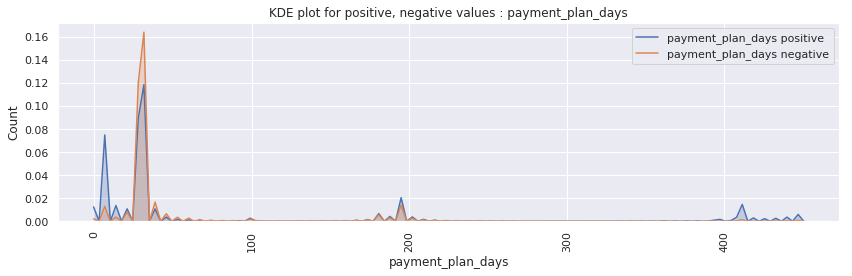

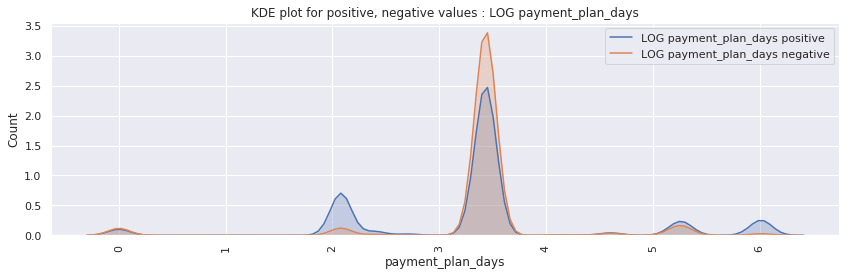

In [0]:
#################### payment_plan_days ... raw & log
#------------------------------------------------------------------
min_value = df_train_test["payment_plan_days"].min()
df_train_test["payment_plan_days_log"] = df_train_test["payment_plan_days"].apply(lambda x: np.log(x - min_value + 1))
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "payment_plan_days")

def add_payment_plan_days_log(usecols=usecols, column_name="payment_plan_days_log"):
    usecols.append(column_name)

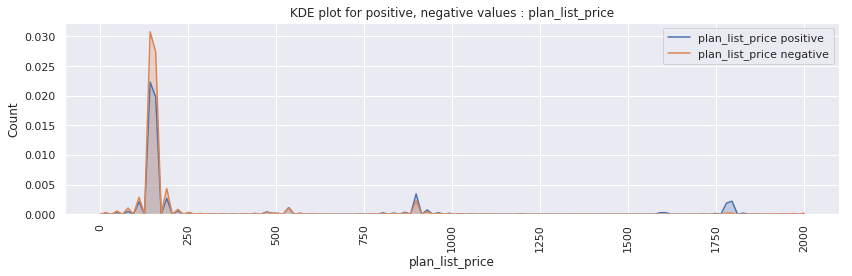

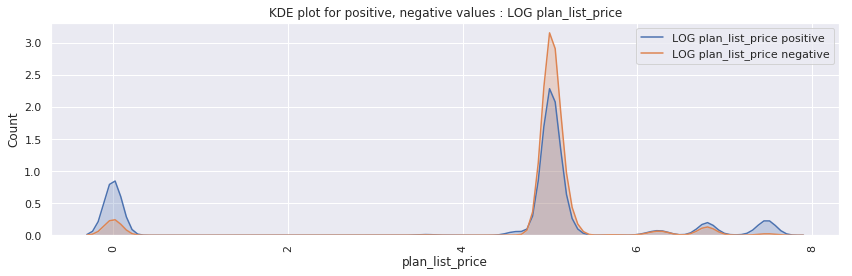

In [0]:
#################### plan_list_price
#------------------------------------------------------------------
min_value = df_train_test["plan_list_price"].min()
df_train_test["plan_list_price_log"] = df_train_test["plan_list_price"].apply(lambda x: np.log(x - min_value + 1))
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "plan_list_price")

def add_plan_list_price_log(usecols=usecols, column_name="plan_list_price_log"):
    usecols.append(column_name)

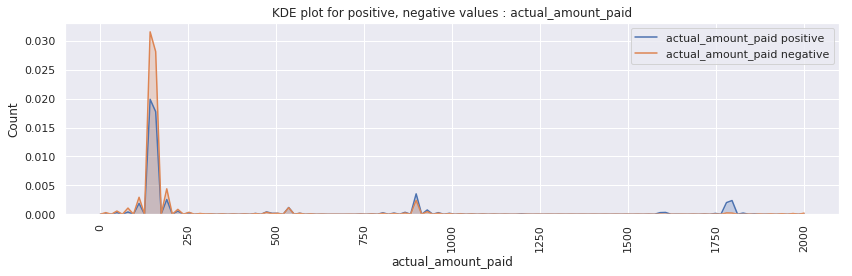

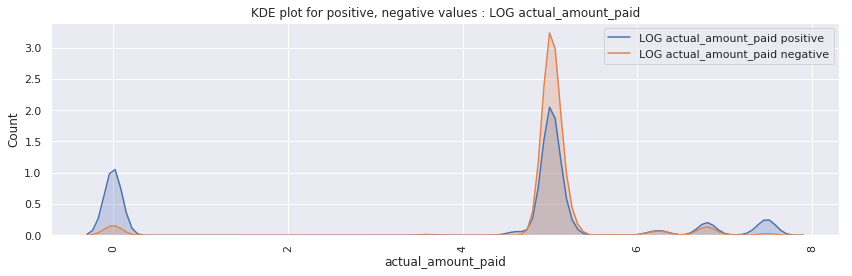

In [0]:
#################### actual_amount_paid
#------------------------------------------------------------------
min_value = df_train_test["actual_amount_paid"].min()
df_train_test["actual_amount_paid_log"] = df_train_test["actual_amount_paid"].apply(lambda x: np.log(x - min_value + 1))
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "actual_amount_paid")

def add_actual_amount_paid_log(usecols=usecols, column_name="actual_amount_paid_log"):
    usecols.append(column_name)


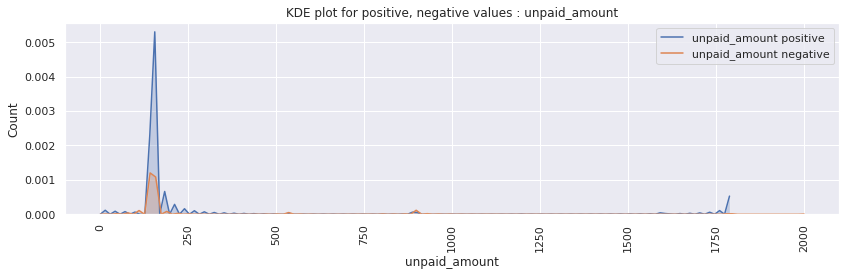

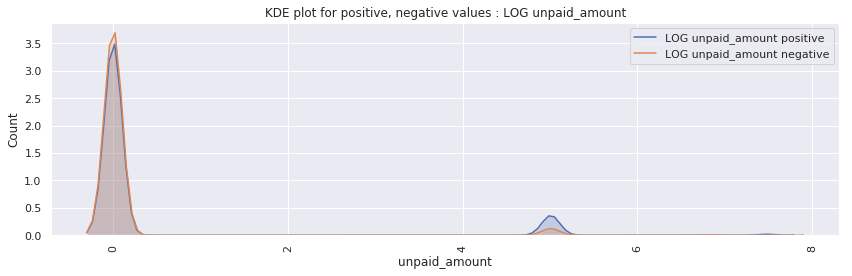

In [0]:
#################### unpaid_amount = actual_amount_paid - plan_list_price
def calc_unpaid_amount(df):
    df["unpaid_amount"] = (df["actual_amount_paid"] - df["plan_list_price"]).apply(lambda x: abs(x))
#------------------------------------------------------------------
calc_unpaid_amount(df_train_test)
calc_unpaid_amount(df_train)
min_value = df_train_test["unpaid_amount"].min()
df_train_test["unpaid_amount_log"] = df_train_test["unpaid_amount"].apply(lambda x: np.log(x - min_value + 1))
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "unpaid_amount")

def add_unpaid_amount_log(usecols=usecols, column_name="unpaid_amount_log"):
    usecols.append(column_name)


In [0]:
#################### is_auto_renew
#------------------------------------------------------------------
#------------------------------------------------------------------

df_is_auto_renew = feature_target_relation(df_train, "is_auto_renew", min_samples=3000)

def add_is_auto_renew(usecols=usecols, column_name="is_auto_renew"):
    usecols.append(column_name)


********** Length of unique values :  2
is_auto_renew with high positive ratio


,is_auto_renew,positive,negative,positive_ratio
0,1,37986,15536,0.709727
1,0,81444,204414,0.284911


is_auto_renew with high negative ratio


,is_auto_renew,positive,negative,positive_ratio
1,0,81444,204414,0.284911
0,1,37986,15536,0.709727


In [0]:
#################### transaction_date
def calc_month(df, column_name):
    df[column_name+"_month"] = pd.DatetimeIndex(df['transaction_date']).month
    
def calc_day(df, column_name):
    df[column_name+"_day"] = pd.DatetimeIndex(df['transaction_date']).day
    
def calc_dayofweek(df, column_name):
    df[column_name+"_dayofweek"] = pd.DatetimeIndex(df['transaction_date']).dayofweek
    
#------------------------------------------------------------------
calc_month(df_train_test, "transaction_date")
calc_day(df_train_test, "transaction_date")
calc_dayofweek(df_train_test, "transaction_date")
calc_month(df_train, "transaction_date")
calc_day(df_train, "transaction_date")
calc_dayofweek(df_train, "transaction_date")
customized_get_dummies(df_train_test, "transaction_date_month")
customized_get_dummies(df_train_test, "transaction_date_day")
customized_get_dummies(df_train_test, "transaction_date_dayofweek")
#------------------------------------------------------------------

df_transaction_date_month = feature_target_relation(df_train, "transaction_date_month", min_samples=1000)
df_transaction_date_day = feature_target_relation(df_train, "transaction_date_day", min_samples=1000)
df_transaction_date_dayofweek = feature_target_relation(df_train, "transaction_date_dayofweek", min_samples=1000)

def add_transaction_date_month(num_features, df=df_transaction_date_month, 
                               usecols=usecols, column_name="transaction_date_month"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
            
def add_transaction_date_day(num_features, df=df_transaction_date_day, 
                               usecols=usecols, column_name="transaction_date_day"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
            
def add_transaction_date_dayofweek(num_features, df=df_transaction_date_dayofweek, 
                               usecols=usecols, column_name="transaction_date_dayofweek"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))

********** Length of unique values :  12
transaction_date_month with high positive ratio


,transaction_date_month,positive,negative,positive_ratio
0,10,11364,13066,0.465166
1,9,14822,22666,0.395380
2,6,13270,21486,0.381805
3,8,13169,22154,0.372817
4,1,7292,13532,0.350173


transaction_date_month with high negative ratio


,transaction_date_month,positive,negative,positive_ratio
11,3,9877,21700,0.312791
10,11,5611,12311,0.313079
9,2,8823,19131,0.315626
8,4,9092,19693,0.315859
7,5,9328,20171,0.316214


********** Length of unique values :  31
transaction_date_day with high positive ratio


,transaction_date_day,positive,negative,positive_ratio
0,24,4716,7552,0.384415
1,2,4637,7682,0.376410
2,23,4262,7110,0.374780
3,22,4303,7218,0.373492
4,4,4251,7311,0.367670


transaction_date_day with high negative ratio


,transaction_date_day,positive,negative,positive_ratio
30,18,3408,7445,0.314015
29,16,3744,7554,0.331386
28,17,3691,7356,0.334118
27,9,3735,7387,0.335821
26,6,3885,7654,0.336684


********** Length of unique values :  7
transaction_date_dayofweek with high positive ratio


,transaction_date_dayofweek,positive,negative,positive_ratio
0,4,17505,31068,0.360385
1,3,17305,31256,0.356356
2,5,17568,31745,0.356255
3,0,17404,32139,0.351291
4,6,17362,32498,0.348215


transaction_date_dayofweek with high negative ratio


,transaction_date_dayofweek,positive,negative,positive_ratio
6,1,16029,30526,0.344302
5,2,16257,30718,0.346078
4,6,17362,32498,0.348215
3,0,17404,32139,0.351291
2,5,17568,31745,0.356255


In [0]:
#################### membership_expire_date
def calc_month(df, column_name):
    df[column_name+"_month"] = pd.DatetimeIndex(df['membership_expire_date']).month
    
def calc_day(df, column_name):
    df[column_name+"_day"] = pd.DatetimeIndex(df['membership_expire_date']).day
    
def calc_dayofweek(df, column_name):
    df[column_name+"_dayofweek"] = pd.DatetimeIndex(df['membership_expire_date']).dayofweek
    
#------------------------------------------------------------------
calc_month(df_train_test, "membership_expire_date")
calc_day(df_train_test, "membership_expire_date")
calc_dayofweek(df_train_test, "membership_expire_date")
calc_month(df_train, "membership_expire_date")
calc_day(df_train, "membership_expire_date")
calc_dayofweek(df_train, "membership_expire_date")
customized_get_dummies(df_train_test, "membership_expire_date_month")
customized_get_dummies(df_train_test, "membership_expire_date_day")
customized_get_dummies(df_train_test, "membership_expire_date_dayofweek")
#------------------------------------------------------------------

df_membership_expire_date_month = feature_target_relation(df_train, "membership_expire_date_month", min_samples=1000)
df_membership_expire_date_day = feature_target_relation(df_train, "membership_expire_date_day", min_samples=1000)
df_membership_expire_date_dayofweek = feature_target_relation(df_train, "membership_expire_date_dayofweek", min_samples=1000)

def add_membership_expire_date_month(num_features, df=df_membership_expire_date_month, 
                               usecols=usecols, column_name="membership_expire_date_month"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
            
def add_membership_expire_date_day(num_features, df=df_membership_expire_date_day, 
                               usecols=usecols, column_name="membership_expire_date_day"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
            
def add_membership_expire_date_dayofweek(num_features, df=df_membership_expire_date_dayofweek, 
                               usecols=usecols, column_name="membership_expire_date_dayofweek"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))

********** Length of unique values :  12
membership_expire_date_month with high positive ratio


,membership_expire_date_month,positive,negative,positive_ratio
0,9,17989,23555,0.433011
1,10,16732,23325,0.417705
2,6,12903,21471,0.375371
3,7,11808,20611,0.364231
4,2,5783,11557,0.333506


membership_expire_date_month with high negative ratio


,membership_expire_date_month,positive,negative,positive_ratio
11,4,8550,20912,0.290204
10,1,5236,12459,0.295903
9,5,8955,19986,0.309423
8,8,10188,22124,0.315301
7,11,5456,11766,0.316804


********** Length of unique values :  31
membership_expire_date_day with high positive ratio


,membership_expire_date_day,positive,negative,positive_ratio
0,31,3386,3569,0.486844
1,15,7131,9265,0.434923
2,30,4154,6531,0.388769
3,29,4051,6718,0.376172
4,1,3972,6708,0.371910


membership_expire_date_day with high negative ratio


,membership_expire_date_day,positive,negative,positive_ratio
30,25,3296,7040,0.318885
29,17,3642,7555,0.325266
28,23,3639,7454,0.328045
27,22,3520,7186,0.328788
26,14,3493,7113,0.329342


********** Length of unique values :  7
membership_expire_date_dayofweek with high positive ratio


,membership_expire_date_dayofweek,positive,negative,positive_ratio
0,0,20616,33147,0.383461
1,3,17290,30475,0.361981
2,4,17239,30840,0.358556
3,2,16595,31793,0.342957
4,1,16291,31769,0.338972


membership_expire_date_dayofweek with high negative ratio


,membership_expire_date_dayofweek,positive,negative,positive_ratio
6,6,15706,31071,0.335763
5,5,15693,30855,0.337136
4,1,16291,31769,0.338972
3,2,16595,31793,0.342957
2,4,17239,30840,0.358556


### 2.2.2 members.csv

In [0]:
print("Shape of df_train_test : ", df_train_test.shape)
print("Shape of df_train : ", df_train.shape)
print("Shape of df_members : ", df_members.shape)

Shape of df_train_test :  (412874, 143)
Shape of df_train :  (339380, 23)
Shape of df_members :  (174878, 6)


In [0]:
df_train_test = pd.merge(df_train_test, df_members, on="msno")
df_train = pd.merge(df_train, df_members, on="msno")
print("Shape of df_train_test : ", df_train_test.shape)
print("Shape of df_train : ", df_train.shape)
df_train_test.head(2)

Shape of df_train_test :  (412874, 148)
Shape of df_train :  (339380, 28)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,DT_M_EXP,DT_M,transaction_date_ym,expired_days,expired_over_74days,mode,payment_method_id_39,payment_method_id_37,payment_method_id_38,payment_method_id_41,payment_method_id_40,payment_method_id_36,payment_method_id_20,payment_method_id_28,payment_method_id_35,payment_method_id_32,payment_method_id_29,payment_plan_days_categorized,payment_plan_days_categorized_30,payment_plan_days_categorized_7,payment_plan_days_categorized_365,payment_plan_days_categorized_180,payment_plan_days_categorized_0,payment_plan_days_log,plan_list_price_log,actual_amount_paid_log,unpaid_amount,unpaid_amount_log,transaction_date_month,transaction_date_day,transaction_date_dayofweek,...,membership_expire_date_day_4,membership_expire_date_day_5,membership_expire_date_day_6,membership_expire_date_day_7,membership_expire_date_day_8,membership_expire_date_day_9,membership_expire_date_day_10,membership_expire_date_day_11,membership_expire_date_day_12,membership_expire_date_day_13,membership_expire_date_day_14,membership_expire_date_day_15,membership_expire_date_day_16,membership_expire_date_day_17,membership_expire_date_day_18,membership_expire_date_day_19,membership_expire_date_day_20,membership_expire_date_day_21,membership_expire_date_day_22,membership_expire_date_day_23,membership_expire_date_day_24,membership_expire_date_day_25,membership_expire_date_day_26,membership_expire_date_day_27,membership_expire_date_day_28,membership_expire_date_day_29,membership_expire_date_day_30,membership_expire_date_day_31,membership_expire_date_dayofweek_6,membership_expire_date_dayofweek_0,membership_expire_date_dayofweek_1,membership_expire_date_dayofweek_2,membership_expire_date_dayofweek_3,membership_expire_date_dayofweek_4,membership_expire_date_dayofweek_5,city,bd,gender,registered_via,registration_init_time
0,vYV4UWNY+OSEShex/q8WUeHMd5dS7hyHytgOUTOjOx8=,25,30,150,150,0,2015-01-30,2015-03-01,0,3,1,2015-01,1.0,0,train,0,0,0,0,0,0,0,0,0,0,0,30,1,0,0,0,0,3.433987,5.01728,5.01728,0,0.0,1,30,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17,19,female,3,2014-11-15
1,vYV4UWNY+OSEShex/q8WUeHMd5dS7hyHytgOUTOjOx8=,25,30,150,150,0,2015-03-02,2015-04-01,0,4,3,2015-03,1.0,0,train,0,0,0,0,0,0,0,0,0,0,0,30,1,0,0,0,0,3.433987,5.01728,5.01728,0,0.0,3,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,17,19,female,3,2014-11-15


In [0]:
#################### city
#------------------------------------------------------------------
customized_get_dummies(df_train_test, "city", min_samples=3000)
#------------------------------------------------------------------

df_city = feature_target_relation(df_train, "city", min_samples=3000)

def add_city(num_features, df=df_city, 
                               usecols=usecols, column_name="city"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))


********** Length of unique values :  17
city with high positive ratio


,city,positive,negative,positive_ratio
0,1,45102,46487,0.492439
1,9,3363,5371,0.385047
2,14,3287,6558,0.333875
3,17,939,2094,0.309594
4,22,7482,16819,0.307889


city with high negative ratio


,city,positive,negative,positive_ratio
16,3,888,2577,0.256277
15,21,1065,2847,0.272239
14,11,1549,3991,0.279603
13,13,15591,39851,0.281213
12,10,1225,3094,0.283630


In [0]:
#################### bd
#------------------------------------------------------------------
customized_get_dummies(df_train_test, "bd", min_samples=3000)
#------------------------------------------------------------------

df_bd = feature_target_relation(df_train, "bd", min_samples=3000)

def add_bd(num_features, df=df_bd, 
                               usecols=usecols, column_name="bd"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))


********** Length of unique values :  22
bd with high positive ratio


,bd,positive,negative,positive_ratio
0,37,2042,1830,0.527376
1,36,1635,1798,0.476260
2,0,48119,53163,0.475099
3,35,1841,2219,0.453448
4,34,1952,2398,0.448736


bd with high negative ratio


,bd,positive,negative,positive_ratio
21,18,2189,9256,0.191263
20,19,2976,12562,0.191530
19,20,4039,16222,0.199349
18,21,4135,16255,0.202795
17,22,4339,15512,0.218578


In [0]:
#################### gender
#------------------------------------------------------------------
customized_get_dummies(df_train_test, "gender", min_samples=3000)
#------------------------------------------------------------------

df_gender = feature_target_relation(df_train, "gender", min_samples=3000)

def add_gender(num_features, df=df_gender, 
                               usecols=usecols, column_name="gender"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))


********** Length of unique values :  2
gender with high positive ratio


,gender,positive,negative,positive_ratio
0,female,33746,76132,0.307122
1,male,37921,90583,0.295096


gender with high negative ratio


,gender,positive,negative,positive_ratio
1,male,37921,90583,0.295096
0,female,33746,76132,0.307122


In [0]:
#################### registered_vi
#------------------------------------------------------------------
customized_get_dummies(df_train_test, "registered_via", min_samples=3000)
#------------------------------------------------------------------

df_registered_via = feature_target_relation(df_train, "registered_via", min_samples=3000)

def add_registered_via(num_features, df=df_registered_via, 
                               usecols=usecols, column_name="registered_via"):
    for feature_value in df.sort_values("positive_ratio", ascending=False)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))
    for feature_value in df.sort_values("positive_ratio", ascending=True)[column_name][:num_features]:
        if column_name+"_"+str(feature_value) not in usecols:
            usecols.append(column_name+"_"+str(feature_value))


********** Length of unique values :  4
registered_via with high positive ratio


,registered_via,positive,negative,positive_ratio
0,7,23687,9168,0.720956
1,4,15058,18729,0.445674
2,9,49705,110344,0.310561
3,3,30957,81704,0.274780


registered_via with high negative ratio


,registered_via,positive,negative,positive_ratio
3,3,30957,81704,0.274780
2,9,49705,110344,0.310561
1,4,15058,18729,0.445674
0,7,23687,9168,0.720956


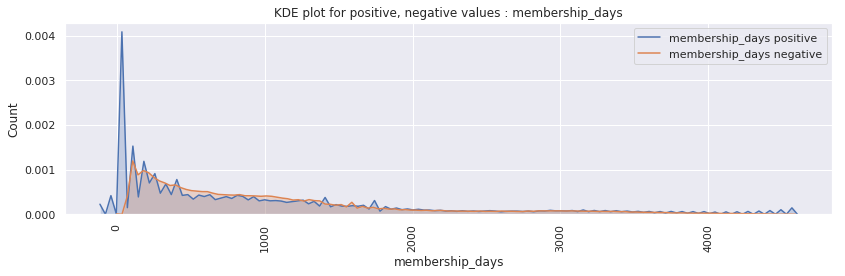

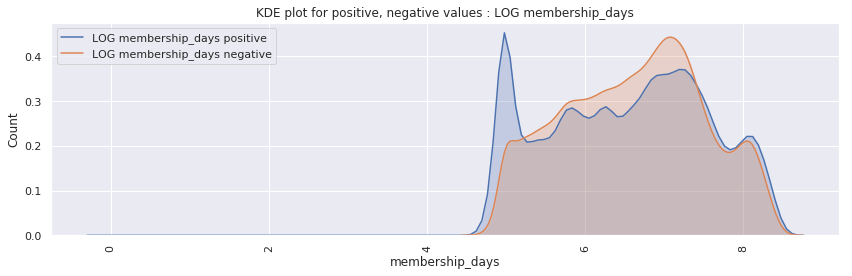

In [0]:
#################### membership_days = membership_expire_date - registration_init_time
def calc_membership_days(df):
    df["membership_days"] = pd.Series(pd.DatetimeIndex(df["membership_expire_date"]) - pd.DatetimeIndex(df["registration_init_time"])).dt.days
#------------------------------------------------------------------
calc_membership_days(df_train_test)
calc_membership_days(df_train)
min_value = df_train_test["membership_days"].min()
df_train_test["membership_days_log"] = df_train_test["membership_days"].apply(lambda x: np.log(x - min_value + 1))
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "membership_days")

def add_membership_days_log(usecols=usecols, column_name="membership_days"):
    usecols.append(column_name)


### 2.2.3 user_logs.csv

In [0]:
print("Shape of df_user_logs : ", df_user_logs.shape)
print("Shape of df_train_test : ", df_train_test.shape)

Shape of df_user_logs :  (29671544, 10)
Shape of df_train_test :  (412874, 197)


In [0]:
# Fill Outliers : df_user_logs.total_secs = -9.223372e+15 (<0)

def fill_outlier_for_total_secs(df_user_logs=df_user_logs):
    '''
    Using "Non-negative least squares" for Regression Task. 
    Library : scipy.optimize.nnls
    '''
    print("Start : Number of too small Outliers : ", len(df_user_logs[df_user_logs.total_secs<0]))
    print("Start : Number of too large Outliers : ", len(df_user_logs[df_user_logs.total_secs>60*60*24*3]))
    X_train = df_user_logs[(df_user_logs.total_secs>0)&(df_user_logs.total_secs<60*60*24*3)][["num_25", "num_50", "num_75", "num_985", "num_100"]]
    X_test_neg = df_user_logs[df_user_logs.total_secs<0][["num_25", "num_50", "num_75", "num_985", "num_100"]]
    X_test_pos = df_user_logs[df_user_logs.total_secs>60*60*24*3][["num_25", "num_50", "num_75", "num_985", "num_100"]]
    y_train = df_user_logs[(df_user_logs.total_secs>0)&(df_user_logs.total_secs<60*60*24*3)]["total_secs"]
    clf = LinearRegression(n_jobs=-1, normalize=True).fit(X_train, y_train)
    if len(X_test_neg)>0 : y_preds_neg = clf.predict(X_test_neg)
    if len(X_test_pos)>0 : y_preds_pos = clf.predict(X_test_pos)
    if len(X_test_neg)>0 : df_user_logs.loc[df_user_logs.total_secs<0, "total_secs"] = y_preds_neg
    if len(X_test_pos)>0 : df_user_logs.loc[df_user_logs.total_secs>60*60*24*3, "total_secs"] = y_preds_pos
    print("Finished : Number of too small Outliers : ", len(df_user_logs[df_user_logs.total_secs<0]))
    print("Finished : Number of too large Outliers : ", len(df_user_logs[df_user_logs.total_secs>60*60*24*3]))
    if len(df_user_logs[df_user_logs.total_secs<0]) > 0:
        print("Forcing too small Outliers to 0 ...")
        df_user_logs.loc[df_user_logs.total_secs<0, "total_secs"] = 0.0
    if len(df_user_logs[df_user_logs.total_secs>60*60*24*3]) > 0:
        print("Forcing too large Outliers to 60*60*24*3 ...")
        df_user_logs.loc[df_user_logs.total_secs>60*60*24*3, "total_secs"] = 60*60*24*3

fill_outlier_for_total_secs(df_user_logs)

Start : Number of too small Outliers :  5624
Start : Number of too large Outliers :  1355
Finished : Number of too small Outliers :  0
Finished : Number of too large Outliers :  490
Forcing too large Outliers to 60*60*24*3 ...


In [0]:
if WRITE:
    # getting transaction date DataFrame for 3 months before the membership expiring date
    df_user_log_3months = df_train_test[["msno","membership_expire_date"]].reset_index().rename(columns={"membership_expire_date":"date", "index":"tran_id"})

    print("Started Shape : ", df_user_log_3months.shape)
    df_user_log_3months_copy = df_user_log_3months.copy()
    transaction_dfs = []
    for d in tqdm_notebook(range(1, 91)):
        df_tmp = df_user_log_3months_copy.copy()
        df_tmp["date"] = (pd.DatetimeIndex(df_user_log_3months_copy.date) - pd.Timedelta(days=d)).astype(str)
        transaction_dfs.append(df_tmp)
    df_user_log_3months = pd.concat(transaction_dfs).sort_values("tran_id").reset_index(drop=True)
    print("After Finished Shape : ", df_user_log_3months.shape)

    df_user_log_3months = df_user_log_3months.merge(df_user_logs, on=["msno", "date"], how="left")

    df_user_log_3months = df_user_log_3months.drop(columns=["date_ym"]).fillna(0.0).sort_values(["tran_id", "date"])
    display(df_user_log_3months.head(2))
    df_user_log_3months.to_csv(PATH+'/user_log_3months_201.csv.gz', compression='gzip', index=False)
    
if READ:
    df_user_log_3months = pd.read_csv(PATH+'/user_log_3months_201.csv.gz', compression='gzip')
    print("Shape : ", df_user_log_3months.shape)
    display(df_user_log_3months.head(2))
    

Shape :  (37158660, 10)


,tran_id,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,0,vYV4UWNY+OSEShex/q8WUeHMd5dS7hyHytgOUTOjOx8=,2014-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,vYV4UWNY+OSEShex/q8WUeHMd5dS7hyHytgOUTOjOx8=,2014-12-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shape of df_user_logs :  (412874, 199)


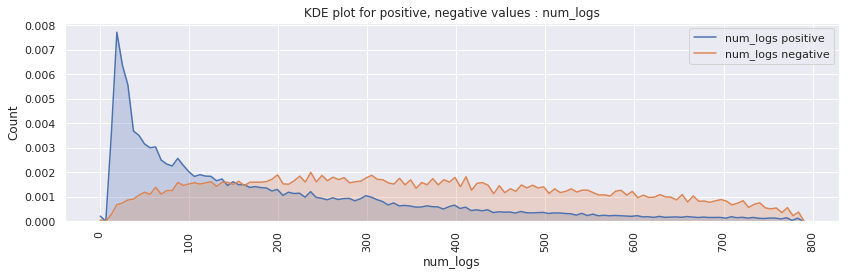

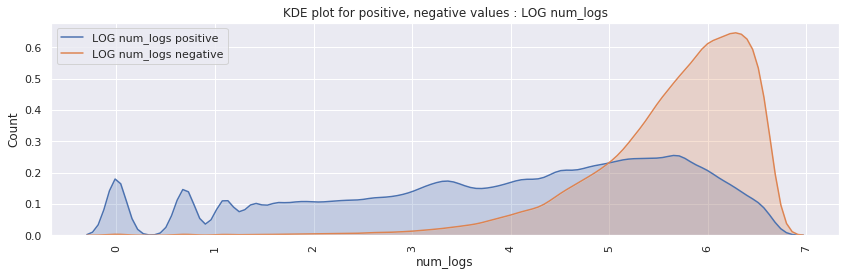

In [0]:
#################### num_logs
def calc_num_logs(df, num_logs):
    df["num_logs"] = pd.merge(df[["msno"]], num_logs, on="msno")["sum"]
#------------------------------------------------------------------
num_logs = df_user_logs[["msno", "total_secs"]].groupby("msno", as_index=False).count().rename(columns={"total_secs":"sum"})
calc_num_logs(df_train_test, num_logs)
calc_num_logs(df_train, num_logs)
min_value = df_train_test["num_logs"].min()
df_train_test["num_logs_log"] = df_train_test["num_logs"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_user_logs : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "num_logs")

def add_num_logs_log(usecols=usecols, column_name="num_logs"):
    usecols.append(column_name)


Shape of df_train_test :  (412874, 201)


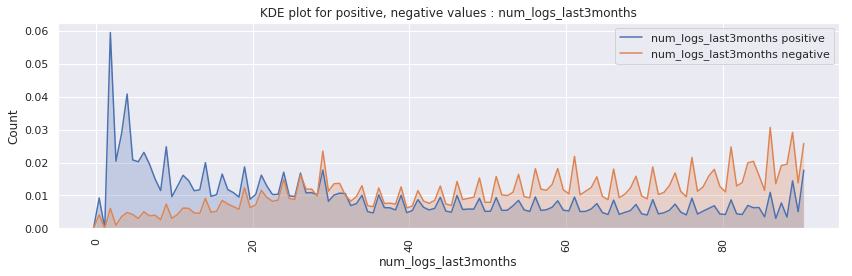

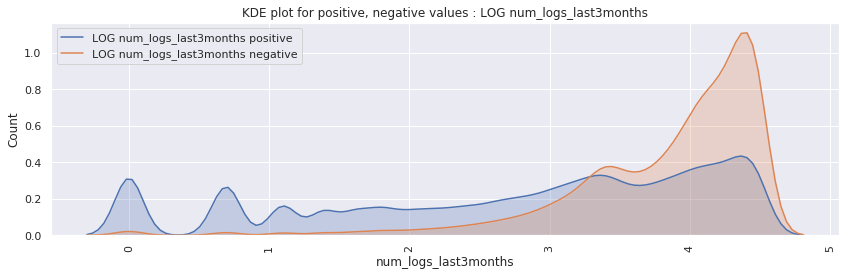

In [0]:
#################### num_logs_last3months
def calc_num_logs_last3months(df_train, df_train_test, df_user_log_3months=df_user_log_3months):
    df_user_log_3months["has_record"] = (df_user_log_3months.total_secs>0).astype(int)
    df_train_test["num_logs_last3months"] = df_user_log_3months.groupby("tran_id").has_record.sum()
    df_train["num_logs_last3months"] = df_user_log_3months.groupby("tran_id").has_record.sum()[df_train_test["mode"]=="train"].reset_index(drop=True)
#------------------------------------------------------------------
calc_num_logs_last3months(df_train, df_train_test)
min_value = df_train_test["num_logs_last3months"].min()
df_train_test["num_logs_last3months_log"] = df_train_test["num_logs_last3months"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_train_test : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "num_logs_last3months")

def add_num_logs_last3months_log(usecols=usecols, column_name="num_logs_last3months"):
    usecols.append(column_name)

Shape of df_train_test :  (412874, 203)


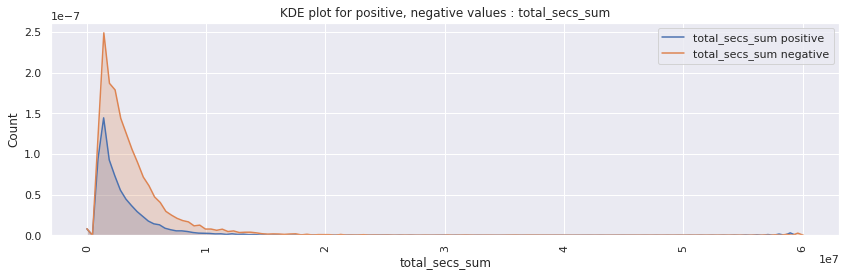

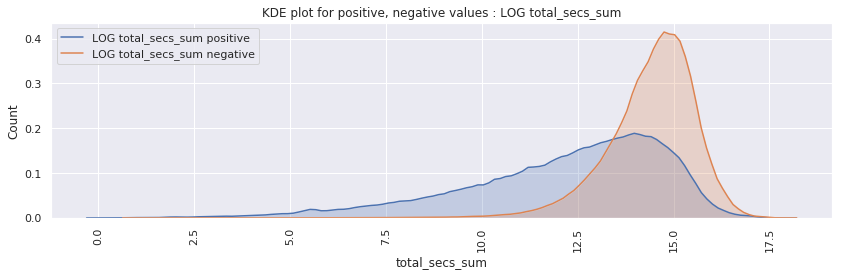

In [0]:
#################### total_secs_sum
def calc_total_secs_sum(df, total_secs_sum):
    df["total_secs_sum"] = pd.merge(df[["msno"]], total_secs_sum, on="msno")["sum"]
#------------------------------------------------------------------
total_secs_sum = df_user_logs[["msno", "total_secs"]].groupby("msno", as_index=False).sum().rename(columns={"total_secs":"sum"})
calc_total_secs_sum(df_train_test, total_secs_sum)
calc_total_secs_sum(df_train, total_secs_sum)
min_value = df_train_test["total_secs_sum"].min()
df_train_test["total_secs_sum_log"] = df_train_test["total_secs_sum"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_train_test : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "total_secs_sum")

def add_total_secs_sum_log(usecols=usecols, column_name="total_secs_sum"):
    usecols.append(column_name)


Shape of df_train_test :  (412874, 205)


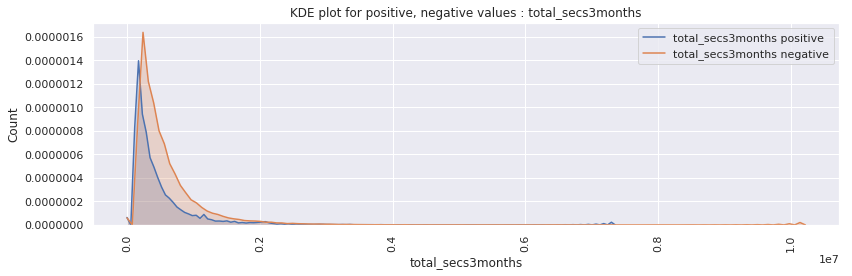

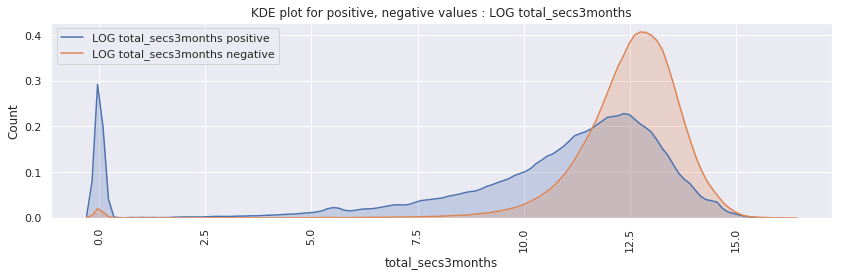

In [0]:
#################### total_secs3months
def calc_total_secs_last3months(df_train, df_train_test, df_user_log_3months=df_user_log_3months):
    df_train_test["total_secs3months"] = df_user_log_3months.groupby("tran_id").total_secs.sum()
    df_train["total_secs3months"] = df_user_log_3months.groupby("tran_id").total_secs.sum()[df_train_test["mode"]=="train"].reset_index(drop=True)
#------------------------------------------------------------------
calc_total_secs_last3months(df_train, df_train_test)
min_value = df_train_test["total_secs3months"].min()
df_train_test["total_secs3months_log"] = df_train_test["total_secs3months"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_train_test : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "total_secs3months")

def add_total_secs3months_log(usecols=usecols, column_name="total_secs3months"):
    usecols.append(column_name)

Shape of df_train_test :  (412874, 207)


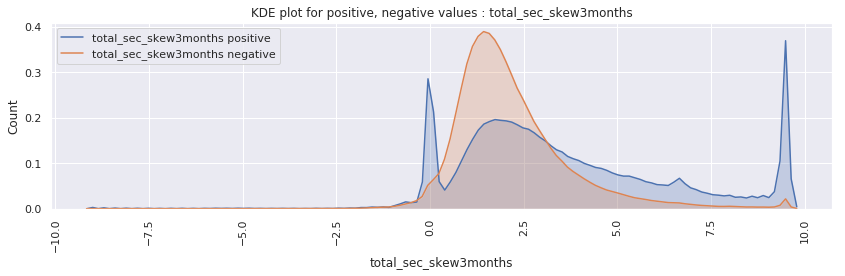

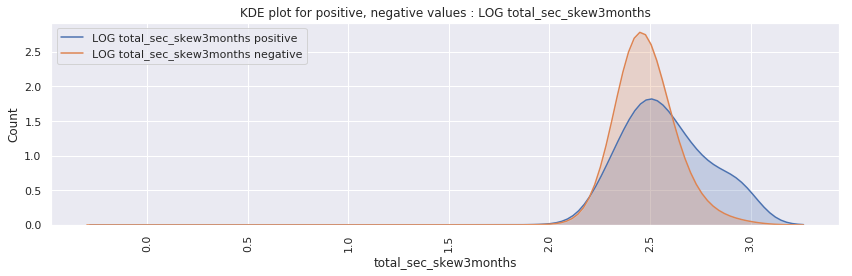

In [0]:
#################### total_sec_skew3months
def calc_total_sec_skew3months(df_train, df_train_test, df_user_log_3months=df_user_log_3months):
    df_train_test["total_sec_skew3months"] = df_user_log_3months.groupby("tran_id").total_secs.skew()
    df_train["total_sec_skew3months"] = df_user_log_3months.groupby("tran_id").total_secs.skew()[df_train_test["mode"]=="train"].reset_index(drop=True)
#------------------------------------------------------------------
calc_total_sec_skew3months(df_train, df_train_test)
min_value = df_train_test["total_sec_skew3months"].min()
df_train_test["total_sec_skew3months_log"] = df_train_test["total_sec_skew3months"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_train_test : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "total_sec_skew3months")

def add_total_sec_skew3months(usecols=usecols, column_name="total_sec_skew3months"):
    usecols.append(column_name)

Shape of df_train_test :  (412874, 209)


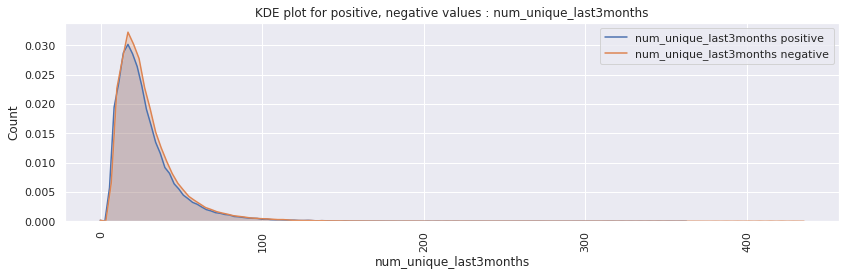

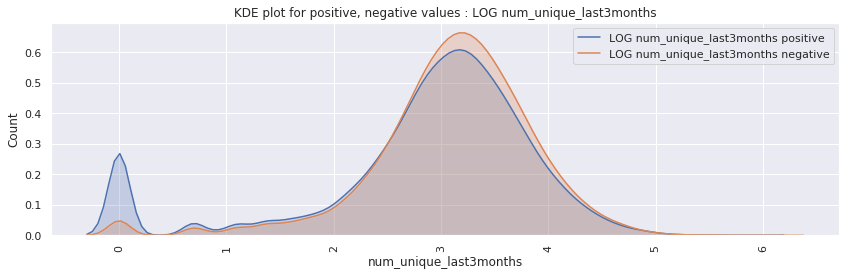

In [0]:
#################### num_unique_last3months
def calc_num_unique_last3months(df_train, df_train_test, df_user_log_3months=df_user_log_3months):
    df_train_test["num_unique_last3months"] = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_unq.mean()
    df_train_test["num_unique_last3months"] = df_train_test["num_unique_last3months"].fillna(0.0)
    df_train["num_unique_last3months"] = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_unq.mean()[df_train_test["mode"]=="train"].reset_index(drop=True)
    df_train["num_unique_last3months"] = df_train["num_unique_last3months"].fillna(0.0)
#------------------------------------------------------------------
calc_num_unique_last3months(df_train, df_train_test)
min_value = df_train_test["num_unique_last3months"].min()
df_train_test["num_unique_last3months_log"] = df_train_test["num_unique_last3months"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_train_test : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "num_unique_last3months")

def add_num_unique_last3months_log(usecols=usecols, column_name="num_unique_last3months_log"):
    usecols.append(column_name)

Shape of df_train_test :  (412874, 211)


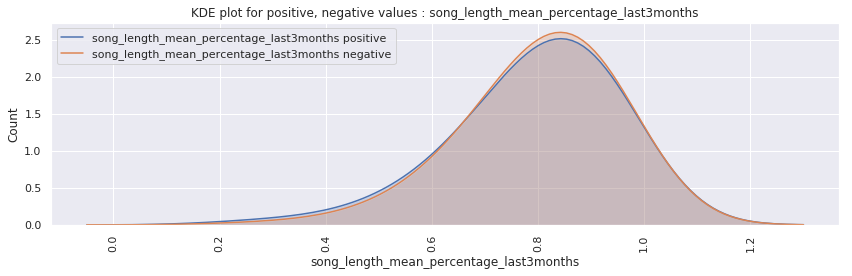

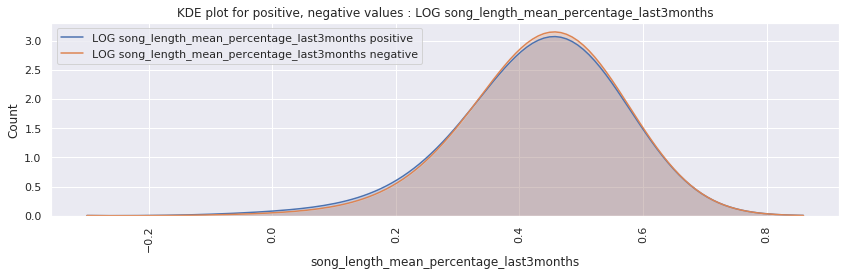

In [0]:
#################### song_length_mean_percentage_last3months
def calc_song_length_mean_percentage_last3months(df_train, df_train_test, df_user_log_3months=df_user_log_3months):
    num_25_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_25.sum()
    num_50_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_50.sum()
    num_75_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_75.sum()
    num_985_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_985.sum()
    num_100_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_100.sum()
    song_length_mean_percentage = (num_25_all*0.25+num_50_all*0.5+num_75_all*0.75+num_985_all*0.985+num_100_all)/(num_25_all+num_50_all+num_75_all+num_985_all+num_100_all)
    df_train_test["song_length_mean_percentage_last3months"] = song_length_mean_percentage.fillna(0.0)
    df_train["song_length_mean_percentage_last3months"] = song_length_mean_percentage[df_train_test["mode"]=="train"].reset_index(drop=True).fillna(0.0)
#------------------------------------------------------------------
calc_song_length_mean_percentage_last3months(df_train, df_train_test)
min_value = df_train_test["song_length_mean_percentage_last3months"].min()
df_train_test["song_length_mean_percentage_last3months_log"] = df_train_test["song_length_mean_percentage_last3months"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_train_test : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "song_length_mean_percentage_last3months")

def add_song_length_mean_percentage_last3months(usecols=usecols, column_name="song_length_mean_percentage_last3months"):
    usecols.append(column_name)

Shape of df_train_test :  (412874, 213)


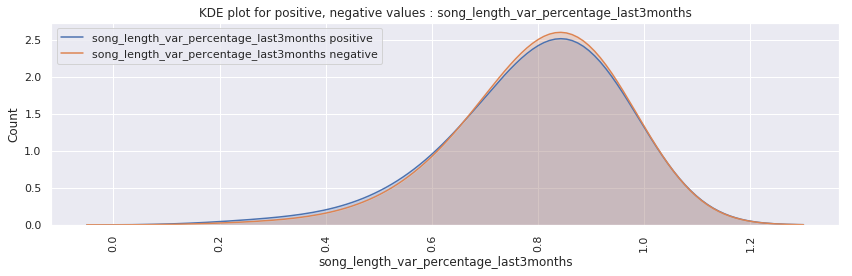

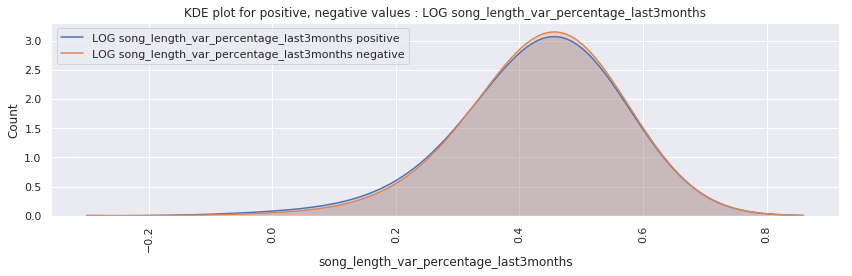

In [0]:
#################### song_length_var_percentage_last3months
def calc_song_length_var_percentage_last3months(df_train, df_train_test, df_user_log_3months=df_user_log_3months):
    num_25_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_25.sum()
    num_50_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_50.sum()
    num_75_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_75.sum()
    num_985_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_985.sum()
    num_100_all = df_user_log_3months[df_user_log_3months.has_record==1].groupby("tran_id").num_100.sum()
    song_length_mean_percentage = (num_25_all*0.25+num_50_all*0.5+num_75_all*0.75+num_985_all*0.985+num_100_all)/(num_25_all+num_50_all+num_75_all+num_985_all+num_100_all)
    song_length_var_percentage = (num_25_all*(0.25-song_length_mean_percentage)+num_50_all*(0.5-song_length_mean_percentage)+
                                  num_75_all*(0.75-song_length_mean_percentage)+num_985_all*(0.985-song_length_mean_percentage)+
                                  num_100_all*(1-song_length_mean_percentage))/(num_25_all+num_50_all+num_75_all+num_985_all+num_100_all)
    df_train_test["song_length_var_percentage_last3months"] = song_length_mean_percentage.fillna(0.0)
    df_train["song_length_var_percentage_last3months"] = song_length_mean_percentage[df_train_test["mode"]=="train"].reset_index(drop=True).fillna(0.0)
#------------------------------------------------------------------
calc_song_length_var_percentage_last3months(df_train, df_train_test)
min_value = df_train_test["song_length_var_percentage_last3months"].min()
df_train_test["song_length_var_percentage_last3months_log"] = df_train_test["song_length_var_percentage_last3months"].apply(lambda x: np.log(x - min_value + 1))
print("Shape of df_train_test : ", df_train_test.shape)
#------------------------------------------------------------------

show_numerical_feature_trends(df_train, "song_length_var_percentage_last3months")

def add_song_length_var_percentage_last3months(usecols=usecols, column_name="song_length_var_percentage_last3months"):
    usecols.append(column_name)

## 2.3 Machine Learning

### 2.3.0 TimeSeriesSplit

In [0]:
from typing import Optional
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

class TimeSeriesSplit(_BaseKFold):  # pylint: disable=abstract-method
    """Time Series cross-validator

    Provides train/test indices to split time series data samples that are observed at fixed time intervals,
    in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is
    inappropriate.

    This cross_validation object is a variation of :class:`TimeSeriesSplit` from the popular scikit-learn package.
    It extends its base functionality to allow for expanding windows, and rolling windows with configurable train and
    test sizes and delays between each. i.e. train on weeks 1-8, skip week 9, predict week 10-11.

    In this implementation we specifically force the test size to be equal across all splits.

    Expanding Window:

            Idx / Time  0..............................................n
            1           |  train  | delay |  test  |                   |
            2           |       train     | delay  |  test  |          |
            ...         |                                              |
            last        |            train            | delay |  test  |

    Rolling Windows:
            Idx / Time  0..............................................n
            1           | train   | delay |  test  |                   |
            2           | step |  train  | delay |  test  |            |
            ...         |                                              |
            last        | step | ... | step |  train  | delay |  test  |

    Parameters:
        n_splits : int, default=5
            Number of splits. Must be at least 4.

        train_size : int, optional
            Size for a single training set.

        test_size : int, optional, must be positive
            Size of a single testing set

        delay : int, default=0, must be positive
            Number of index shifts to make between train and test sets
            e.g,
            delay=0
                TRAIN: [0 1 2 3] TEST: [4]
            delay=1
                TRAIN: [0 1 2 3] TEST: [5]
            delay=2
                TRAIN: [0 1 2 3] TEST: [6]

        force_step_size : int, optional
            Ignore split logic and force the training data to shift by the step size forward for n_splits
            e.g
            TRAIN: [ 0  1  2  3] TEST: [4]
            TRAIN: [ 0  1  2  3  4] TEST: [5]
            TRAIN: [ 0  1  2  3  4  5] TEST: [6]
            TRAIN: [ 0  1  2  3  4  5  6] TEST: [7]

    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit(n_splits=5)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...    print('TRAIN:', train_index, 'TEST:', test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    """

    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        # if n_splits and n_splits < 5:
        #     raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples  and n_features is the number of features.

            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.

            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.

        Yields:
            train : ndarray
                The training set indices for that split.

            test : ndarray
                The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])

In [0]:
### Sort
df_train_test = df_train_test.reset_index().rename(columns={"index":"tran_id"})
df_train_test = df_train_test.sort_values("membership_expire_date").reset_index(drop=True)


### 2.3.1 Gradient Boosting Model
Here, we build a model using meta data for each transaction. LightGBM will be used. 


#### 2.3.1.1 Preprocessing

In [0]:
def lgb_preprocessing(df_train_test, verbose=True):
    usecols = []
    ##### transaction.csv
    add_payment_method_id(int(len(df_payment_method_id)/2), 
                          df=df_payment_method_id, usecols=usecols)
    add_payment_plan_days_categorized(int(len(df_payment_plan_days_categorized)/2), 
                                      df=df_payment_plan_days_categorized, usecols=usecols)
    add_payment_plan_days_log(usecols=usecols)
    add_plan_list_price_log(usecols=usecols)
    add_actual_amount_paid_log(usecols=usecols)
    add_unpaid_amount_log(usecols=usecols)
    add_is_auto_renew(usecols=usecols)
    add_transaction_date_month(int(len(df_transaction_date_month)/2), 
                               df=df_transaction_date_month, usecols=usecols)
    add_transaction_date_day(int(len(df_transaction_date_day)/2), df=df_transaction_date_day, usecols=usecols)
    add_transaction_date_dayofweek(int(len(df_transaction_date_dayofweek)/2), 
                                   df=df_transaction_date_dayofweek, usecols=usecols)
    add_membership_expire_date_month(int(len(df_membership_expire_date_month)/2), 
                                     df=df_membership_expire_date_month, usecols=usecols)
    add_membership_expire_date_day(int(len(df_membership_expire_date_day)/2), 
                                   df=df_membership_expire_date_day, usecols=usecols)
    add_membership_expire_date_dayofweek(int(len(df_membership_expire_date_dayofweek)/2), 
                                         df=df_membership_expire_date_dayofweek, usecols=usecols)
    ##### members.csv
    add_city(int(len(df_city)/2), df=df_city, usecols=usecols)
    add_bd(int(len(df_bd)/2), df=df_bd, usecols=usecols)
    add_gender(int(len(df_gender)/2), df=df_gender, usecols=usecols)
    add_registered_via(int(len(df_registered_via)/2), df=df_registered_via, usecols=usecols)
    add_membership_days_log(usecols=usecols)
    ##### user_logs.csv
    add_num_logs_last3months_log(usecols=usecols)
    add_total_secs3months_log(usecols=usecols)
    add_total_sec_skew3months(usecols=usecols)
    add_num_unique_last3months_log(usecols=usecols)
    add_song_length_mean_percentage_last3months(usecols=usecols)
    add_song_length_var_percentage_last3months(usecols=usecols)
    ##### gather information
    if verbose:
        print("Length of usecols : ", len(usecols))
    X_train = df_train_test[df_train_test["mode"]=="train"][usecols].reset_index(drop=True)
    X_test = df_train_test[df_train_test["mode"]=="test"][usecols].reset_index(drop=True)
    X_train = X_train.fillna(-999)
    X_test = X_test.fillna(-999)
    return X_train, X_test


#### 2.3.1.2 Feature Selection
Permutation Importance will be used to select best features

In [0]:
def permutation_importance(X_val, y_val, model, num_trials=5): 
    perm = {}
    y_pred = model.predict_proba(X_val)[:,1]
    baseline= roc_auc_score(y_val, y_pred)
    for cols in tqdm(X_val.columns):
        diff = []
        for i in range(num_trials):
            value = X_val[cols].copy()
            X_val[cols] = np.random.permutation(X_val[cols].values)
            y_pred = model.predict_proba(X_val)[:,1]
            diff.append(roc_auc_score(y_val, y_pred) - baseline)
            X_val[cols] = value
        perm[cols] = np.mean(diff)
    return perm

In [0]:
########################### Model params
lgb_params = {
    'verbosity': -1, 
    'subsample_freq': 1, 
    'subsample': 0.9, 
    'reg_lambda': 5.0, 
    'reg_alpha': 1.0, 
    'objective': 'binary', 
    'num_leaves': 88, 
    'min_child_samples': 48, 
    'metric': 'auc', 
    'max_depth': 12,
    'learning_rate': 0.03, 
    'colsample_bytree': 0.9, 
    'boosting_type': 'gbdt', 
    'bagging_seed': SEED,
    'random_state' : SEED, 
    'data_random_seed' : SEED, 
    'feature_fraction_seed' : SEED
}

In [0]:
if PERMUTATION_CALC:
    X_train, X_test = lgb_preprocessing(df_train_test)
    y_train = df_train_test[df_train_test['mode']=='train'].expired_over_74days.to_numpy()
    kf = TimeSeriesSplit(
        delay=0, 
        force_step_size=None, 
        n_splits=N_SPLITS, 
        test_size=X_test.shape[0],
        train_size=X_test.shape[0]*2)
    y_oof = np.zeros(X_train.shape[0])
    fold = 1
    permutations = []
    for tr_idx, val_idx in kf.split(X_train, y_train):
        print('-'*20)

        clf = lgb.LGBMClassifier(**lgb_params, n_estimators=12000, n_jobs = -1)
        
        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train[tr_idx], y_train[val_idx]

        clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_vl, y_vl)], 
                eval_metric='auc', verbose=0, early_stopping_rounds=200)
        y_pred_train = clf.predict_proba(X_vl)[:,1]
        y_oof[val_idx] = y_pred_train
        print('ROC AUC baseline score for epoch {} : {}'.format(fold, roc_auc_score(y_vl, y_pred_train)))
        print('permutation calculation ...')
        perm = permutation_importance(X_vl, y_vl, clf)
        permutations.append(perm)
        with open(PICKLE_PATH+f'/perm_{VERSION}_{fold}.pickle', 'wb') as f:
            pickle.dump(perm, f)
        fold+=1
        
        del X_tr, X_vl, y_tr, y_vl, clf
        gc.collect()

    permutation_importances = dict(pd.DataFrame(permutations).mean())
    with open(PICKLE_PATH+f'/permutation_importance_{VERSION}.pickle', 'wb') as f:
        pickle.dump(permutation_importances, f)
else:
    X_train, X_test = lgb_preprocessing(df_train_test)
    y_train = df_train_test[df_train_test['mode']=='train'].expired_over_74days.to_numpy()
    with open(PICKLE_PATH+f'/permutation_importance_kkbox_LL_201.pickle', 'rb') as f:
        permutation_importances = pickle.load(f)

Length of usecols :  166
--------------------
ROC AUC baseline score for epoch 1 : 0.8372839703019656
permutation calculation ...


100%|██████████| 166/166 [06:14<00:00,  2.25s/it]


--------------------
ROC AUC baseline score for epoch 2 : 0.8224908294677702
permutation calculation ...


100%|██████████| 166/166 [09:50<00:00,  3.58s/it]


--------------------
ROC AUC baseline score for epoch 3 : 0.8208121881576361
permutation calculation ...


100%|██████████| 166/166 [13:00<00:00,  4.64s/it]


--------------------


  0%|          | 0/166 [00:00<?, ?it/s]

ROC AUC baseline score for epoch 4 : 0.8283380994782508
permutation calculation ...


100%|██████████| 166/166 [05:05<00:00,  1.81s/it]


--------------------
ROC AUC baseline score for epoch 5 : 0.8480816699511152
permutation calculation ...


100%|██████████| 166/166 [12:12<00:00,  4.38s/it]


In [0]:
NUM_FEATURES = len(permutation_importances.keys())
pd.DataFrame(permutation_importances.items(), columns=["feature", "importance"]).sort_values("importance").head(20)

,feature,importance
91,num_logs_last3months,-0.131753
41,is_auto_renew,-0.059229
107,payment_plan_days_log,-0.026425
0,actual_amount_paid_log,-0.009009
116,total_secs3months,-0.007982
92,num_unique_last3months_log,-0.007976
108,plan_list_price_log,-0.005894
23,city_1,-0.004413
113,song_length_mean_percentage_last3months,-0.002875
104,payment_plan_days_categorized_30,-0.001617


#### 2.3.1.3 Paramater Tuning
Bayesian Optimization will be used to define the best paramaters. 

In [0]:
def get_usecols(top_n_features, perm_dict=permutation_importances, verbose=False):
    usecols = heapq.nsmallest(top_n_features, perm_dict, key=perm_dict.get)
    if verbose: print('usecols Length decreased from {} to {}'.format(len(perm_dict.keys()), len(usecols)))
    return usecols

def calc_cv(usecols, params, X_train=X_train, y_train=y_train):
    X_train_copy = X_train[usecols]
    kf = TimeSeriesSplit(
        delay=0, 
        force_step_size=None, 
        n_splits=3, 
        test_size=X_test.shape[0],
        train_size=X_test.shape[0]*2)
    score = 0.0
    for tr_idx, val_idx in kf.split(X_train_copy, y_train):
        clf = lgb.LGBMClassifier(**params, n_estimators=12000, n_jobs = -1)
        X_tr, X_vl = X_train_copy.iloc[tr_idx, :], X_train_copy.iloc[val_idx, :]
        y_tr, y_vl = y_train[tr_idx], y_train[val_idx]
        clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_vl, y_vl)], 
                eval_metric='auc', verbose=0, early_stopping_rounds=200)
        y_pred_train = clf.predict_proba(X_vl)[:,1]
        score += roc_auc_score(y_vl, y_pred_train) / 3
    return score

def objective(trial):
    ########################### Feature Selection
    usecols = get_usecols(top_n_features=trial.suggest_int('top_n_features', 8, NUM_FEATURES))
    ########################### Model params
    lgb_params = {
        'verbosity': -1, 
        'subsample_freq': 1, 
        'subsample': 0.9, 
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.2, 16.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 2.0),
        'objective': 'binary', 
        'num_leaves': trial.suggest_int('num_leaves', 48, 144),
        'min_child_samples': trial.suggest_int('min_child_samples', 16, 72),
        'metric': 'auc', 
        'max_depth': trial.suggest_int('max_depth', 6, 18),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.007),
        'colsample_bytree': 0.9, 
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'rf']),
        'bagging_seed': SEED,
        'random_state' : SEED, 
        'data_random_seed' : SEED, 
        'feature_fraction_seed' : SEED
    }
    score = calc_cv(usecols=usecols, params=lgb_params)
    return -score


In [0]:
if BAYES_OPT_CALC:
    study = optuna.create_study()
    study.optimize(objective, n_trials=60)
    with open(PICKLE_PATH+f'/bayes_optimization_{VERSION}.pickle', 'wb') as f:
        pickle.dump(study, f)
else:
    with open(PICKLE_PATH+f'/bayes_optimization_kkbox_LL_201.pickle', 'rb') as f:
        study = pickle.load(f)

[I 2019-10-23 09:48:40,538] Finished trial#0 resulted in value: -0.8406967520834844. Current best value is -0.8406967520834844 with parameters: {'top_n_features': 150, 'reg_lambda': 3.9645610976764494, 'reg_alpha': 1.4121096303310485, 'num_leaves': 117, 'min_child_samples': 72, 'max_depth': 11, 'learning_rate': 0.004798889764434039, 'boosting_type': 'rf'}.
[I 2019-10-23 09:49:45,895] Finished trial#1 resulted in value: -0.8402968407358384. Current best value is -0.8406967520834844 with parameters: {'top_n_features': 150, 'reg_lambda': 3.9645610976764494, 'reg_alpha': 1.4121096303310485, 'num_leaves': 117, 'min_child_samples': 72, 'max_depth': 11, 'learning_rate': 0.004798889764434039, 'boosting_type': 'rf'}.
[I 2019-10-23 09:50:24,077] Finished trial#2 resulted in value: -0.8377051208911293. Current best value is -0.8406967520834844 with parameters: {'top_n_features': 150, 'reg_lambda': 3.9645610976764494, 'reg_alpha': 1.4121096303310485, 'num_leaves': 117, 'min_child_samples': 72, 'ma

#### 2.3.1.4 Fitting Starts Here
Fitting using 5-fold together with full data learning prediction

In [0]:
def cross_validation_prediction(usecols, params, y_preds_list, X_train=X_train, y_train=y_train, X_test=X_test):
    X_train_copy = X_train[usecols]
    kf = TimeSeriesSplit(
        delay=0, 
        force_step_size=None, 
        n_splits=N_SPLITS, 
        test_size=X_test.shape[0],
        train_size=X_test.shape[0]*2)
    score = 0.0
    fold = 1
    for tr_idx, val_idx in kf.split(X_train_copy, y_train):
        if fold < 4:
            fold+=1
            continue
        clf = lgb.LGBMClassifier(**params, n_estimators=20000, n_jobs = -1)
        X_tr, X_vl = X_train_copy.iloc[tr_idx, :], X_train_copy.iloc[val_idx, :]
        y_tr, y_vl = y_train[tr_idx], y_train[val_idx]
        clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_vl, y_vl)], 
                eval_metric='auc', verbose=0, early_stopping_rounds=100)
        y_pred_train = clf.predict_proba(X_vl)[:,1]
        y_pred_test = clf.predict_proba(X_test[usecols])[:,1]
        y_preds_list.append(y_pred_test)
        score += roc_auc_score(y_vl, y_pred_train) / (N_SPLITS-3)
        print('ROC AUC baseline score for fold {} : {}'.format(fold, roc_auc_score(y_vl, y_pred_train)))
        fold+=1
    return score, clf.best_iteration_

def full_data_learning_prediction(usecols, params, y_preds_list, best_iter, 
                                  X_train=X_train, y_train=y_train, X_test=X_test):
    for i in range(1, 7):
        params['bagging_seed'] = SEED+SEED*(i+SEED)*i
        params['random_state'] = SEED+SEED*(i+SEED)*i
        params['data_random_seed'] = SEED+SEED*(i+SEED)*i
        params['feature_fraction_seed'] = SEED+SEED*(i+SEED)*i
        clf = lgb.LGBMClassifier(**params, n_estimators=best_iter, n_jobs = -1)
        clf.fit(X_train[usecols], y_train)
        y_pred_test = clf.predict_proba(X_test[usecols])[:,1]
        y_preds_list.append(y_pred_test)
        print(f"No.{i} random_state full data prediction done. ")

def train_and_predict(studt=study, X_train=X_train, y_train=y_train, X_test=X_test):
    best_paramaters = study.best_params
    lgb_params = {
        'verbosity': -1, 
        'subsample_freq': 1, 
        'subsample': 0.9, 
        'reg_lambda': best_paramaters['reg_lambda'],
        'reg_alpha': best_paramaters['reg_alpha'],
        'objective': 'binary', 
        'num_leaves': best_paramaters['num_leaves'],
        'min_child_samples': best_paramaters['min_child_samples'],
        'metric': 'auc', 
        'max_depth': best_paramaters['max_depth'],
        'learning_rate': best_paramaters['learning_rate'],
        'colsample_bytree': 0.9, 
        'boosting_type': best_paramaters['boosting_type'],
        'bagging_seed': SEED,
        'random_state' : SEED, 
        'data_random_seed' : SEED, 
        'feature_fraction_seed' : SEED
    }
    usecols = get_usecols(best_paramaters['top_n_features'])
    ########################### Cross Validation
    y_preds_list = []
    print("---------- Cross Validation ----------")
    cv_score, best_iter = cross_validation_prediction(usecols, lgb_params, y_preds_list)
    ########################### Full Data Learning
    print("---------- Full Data Learning ----------")
    full_data_learning_prediction(usecols, lgb_params, y_preds_list, best_iter)
    return scipy.stats.mstats.gmean(y_preds_list, axis=0)


In [0]:
test_answers = df_train_test[df_train_test['mode']=='test'].expired_over_74days.to_numpy()
if CALC_ML_MODEL:
    y_preds_lightgbm = train_and_predict()
    print("---------- Total Score ----------")
    print("Total Test ROC AUC Score : ", roc_auc_score(test_answers, y_preds_lightgbm))
    print("Total Test F1 Score : ", f1_score(test_answers, np.round(y_preds_lightgbm)))
    print("Total Test PRECISION Score : ", precision_score(test_answers, np.round(y_preds_lightgbm)))
    print("Total Test RECALL Score : ", recall_score(test_answers, np.round(y_preds_lightgbm)))
    print("Total Test ACCURACY Score : ", accuracy_score(test_answers, np.round(y_preds_lightgbm)))

---------- Cross Validation ----------
ROC AUC baseline score for fold 4 : 0.8516743114429417
ROC AUC baseline score for fold 5 : 0.8459110087528603
---------- Full Data Learning ----------
No.1 random_state full data prediction done. 
No.2 random_state full data prediction done. 
No.3 random_state full data prediction done. 
No.4 random_state full data prediction done. 
No.5 random_state full data prediction done. 
No.6 random_state full data prediction done. 
---------- Total Score ----------
Total Test ROC AUC Score :  0.9342282068179112
Total Test F1 Score :  0.8703439360068949
Total Test PRECISION Score :  0.8921620054664421
Total Test RECALL Score :  0.8495675263559166
Total Test ACCURACY Score :  0.8689961085258661


### 2.3.2 Deep Learning Model
Here, we build a deep learning model with meta data and user_logs. 


#### 2.3.2.1 Preprocessing

In [0]:
# Add Transaction Features to df_user_log_3months
df_user_log_3months = pd.merge(
    df_user_log_3months, 
    df_train_test[[
                   'tran_id',
                   'transaction_date',
                   'payment_plan_days_log',
                   'actual_amount_paid_log',
                   'is_auto_renew',
                   'is_cancel',
                   'expired_days'
                       ]].rename(columns={
                             'transaction_date':'date',
                                'payment_plan_days_log':'tran_payment_plan_days_log',  
                                 'actual_amount_paid_log':'tran_actual_amount_paid_log',  
                                   'is_auto_renew':'tran_is_auto_renew',  
                                    'is_cancel':'tran_is_cancel',  
                                      'expired_days':'train_expired_days',  
                                           }), on=['tran_id', 'date'], how='left').fillna(0.0)

In [0]:
# Find Nullified Values
null_columns = df_train_test.columns[df_train_test.isnull().any()]
print('Nullified Columns for df_train_test : ', list(null_columns))
null_columns = df_user_log_3months.columns[df_user_log_3months.isnull().any()]
print('Nullified Columns for df_user_log_3months : ', list(null_columns))
df_train_test = df_train_test.fillna(0.0)


Nullified Columns for df_train_test :  ['gender', 'song_length_mean_percentage_last3months', 'song_length_mean_percentage_last3months_log', 'song_length_var_percentage_last3months', 'song_length_var_percentage_last3months_log']
Nullified Columns for df_user_log_3months :  []


In [117]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler

def standardization(df, usecols):
    for col in tqdm_notebook(usecols):
        df[col] = StandardScaler().fit_transform(np.array(df[col]).reshape(-1, 1))

usecols_ml = get_usecols(study.best_params['top_n_features'])
# usecols_ml = []
# for col in permutation_importances.keys():
#     if permutation_importances[col] < -0.0001:
#         usecols_ml.append(col)
# print(len(usecols_ml))
usecols_dl = ['num_25', 'num_50', 'num_75', 'num_985',
              'num_100', 'num_unq', 'total_secs', 'has_record',
              'tran_payment_plan_days_log', 'tran_actual_amount_paid_log',
              'tran_is_auto_renew', 'tran_is_cancel', 'train_expired_days']

standardization(df_train_test, usecols_ml)
standardization(df_user_log_3months, usecols_dl)


#### 2.3.2.2 Building the Model

In [119]:
import keras
import tensorflow as tf
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, CuDNNGRU, CuDNNLSTM, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D, LeakyReLU
from keras.optimizers import adam
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.models import load_model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.utils import np_utils
from sklearn import metrics

def data_generator(list_IDs, list_ID_all_trn, list_ID_all_usr, 
                   list_ID_all_ans, X_ml, X_dl):
    X_ml_tmp = X_ml[np.isin(list_ID_all_trn, list_IDs)]
    X_dl_tmp = X_dl[np.isin(
        list_ID_all_usr, list_IDs)].reshape(len(list_IDs), 90, len(usecols_dl))
    X = [X_ml_tmp, X_dl_tmp]
    return X

class Attention(Layer):
    def __init__(self, step_dim=300,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)
    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

def auc_roc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc 

def init_model(fc_input_shape, dl_input_shape):
    inp_dl = Input(name="dl_input_layer", shape=dl_input_shape)
    x1 = SpatialDropout1D(0.25)(inp_dl)
    # x1 = CuDNNLSTM(256, return_sequences=True)(x1)
    # x1 = CuDNNLSTM(256, return_sequences=True)(x1)
    # x1 = Attention(dl_input_shape[0])(x1)
    x1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x1)
    x1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x1)
    # x1 = Attention(dl_input_shape[0])(x1)
    x1 = Conv1D(256, kernel_size = 2, padding = "same", kernel_initializer = "he_uniform")(x1)
    # avg_pool1 = GlobalAveragePooling1D()(x1)
    # max_pool1 = GlobalMaxPooling1D()(x1)
    # x1 = concatenate([avg_pool1, max_pool1])
    x1 = GlobalAveragePooling1D()(x1)
    inp_fc = Input(name="fc_input_layer", shape=fc_input_shape)
    x2 = BatchNormalization()(inp_fc)
    x2 = Dropout(0.25)(x2)
    x2 = Dense(256, activation=LeakyReLU(alpha=0.05))(x2)
    x2 = BatchNormalization()(x2)
    # x2 = Dropout(0.1)(x2)
    x2 = Dense(256, activation=LeakyReLU(alpha=0.05))(x2)
    x = concatenate([x1, x2])
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.05))(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.05))(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=[inp_fc, inp_dl], outputs=[out])
    return model

model = init_model([len(usecols_ml)], [90, len(usecols_dl)])
model.compile(optimizer=adam(lr=5e-4), loss="binary_crossentropy", metrics = [auc_roc])
model.summary()


Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dl_input_layer (InputLayer)     (None, 90, 13)       0                                            
__________________________________________________________________________________________________
fc_input_layer (InputLayer)     (None, 12)           0                                            
__________________________________________________________________________________________________
spatial_dropout1d_56 (SpatialDr (None, 90, 13)       0           dl_input_layer[0][0]             
__________________________________________________________________________________________________
batch_normalization_278 (BatchN (None, 12)           48          fc_input_layer[0][0]             
___________________________________________________________________________________________

#### 2.3.2.3 Fitting Starts Here

In [0]:
list_IDs_train = np.array(df_train_test[df_train_test['mode']=='train']['tran_id'])
list_IDs_test = np.array(df_train_test[df_train_test['mode']=='test']['tran_id'])

list_ID_all_trn=np.array(df_train_test['tran_id'])
list_ID_all_usr=np.array(df_user_log_3months['tran_id'])
list_ID_all_ans=np.array(df_train_test[df_train_test['mode']=='train']['tran_id'])
X_ml=df_train_test[usecols_ml].to_numpy().astype('float32')
X_dl=df_user_log_3months[usecols_dl].to_numpy().astype('float32')

## for memory
with open(f'/tmp_df_user_log_3months_{VERSION}.pickle', 'wb') as f:
    pickle.dump(df_user_log_3months, f)
del df_train_test, df_user_log_3months
gc.collect()

X_train = data_generator(
    list_IDs=list_IDs_train,
    list_ID_all_trn=list_ID_all_trn, 
    list_ID_all_usr=list_ID_all_usr, 
    list_ID_all_ans=list_ID_all_ans, 
    X_ml=X_ml, 
    X_dl=X_dl)
X_test = data_generator(
    list_IDs=list_IDs_test,
    list_ID_all_trn=list_ID_all_trn, 
    list_ID_all_usr=list_ID_all_usr, 
    list_ID_all_ans=list_ID_all_ans, 
    X_ml=X_ml, 
    X_dl=X_dl)
y_train = df_train_test[df_train_test['mode']=='train'].expired_over_74days.to_numpy()


In [0]:
VERBOSE = 0

In [0]:
def step_decay(epoch):
    x = max(5e-4*(0.75**epoch), 1e-6)
    return x

def cross_validation_prediction(y_preds_list, usecols_ml=usecols_ml, usecols_dl=usecols_dl, 
                                X_train=X_train, y_train=y_train, X_test=X_test):
    kf = TimeSeriesSplit(
        delay=0, 
        force_step_size=None, 
        n_splits=N_SPLITS, 
        test_size=X_test[0].shape[0],
        train_size=X_test[0].shape[0]*2)
    score = 0.0
    fold = 1
    for tr_idx, val_idx in kf.split(X_train[0], y_train):
        if fold < 4:
            fold+=1
            continue
        X_tr = [X_train[0][tr_idx, :], X_train[1][tr_idx, :]]
        X_vl = [X_train[0][val_idx, :], X_train[1][val_idx, :]]
        y_tr, y_vl = y_train[tr_idx], y_train[val_idx]
        model = init_model([len(usecols_ml)], [90, len(usecols_dl)])
        model.compile(optimizer=adam(lr=5e-4), loss="binary_crossentropy", metrics = [auc_roc])
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001,
                                       patience=5, verbose=VERBOSE, mode='min',
                                       restore_best_weights=True)
        learning_rate_scheduler = LearningRateScheduler(step_decay)
        callbacks = [early_stopping, learning_rate_scheduler]
        history = model.fit(
            X_tr, 
            y_tr, 
            epochs=200,
            batch_size=512,
            shuffle=True,
            verbose=VERBOSE,
            callbacks=callbacks,
            validation_data=(X_vl, y_vl)
            )
        y_pred_train = model.predict(X_vl).flatten()
        score += roc_auc_score(y_vl, y_pred_train) / (N_SPLITS-3)
        y_preds_list.append(model.predict(X_test).flatten())
        print('ROC AUC baseline score for fold {} : {}'.format(fold, roc_auc_score(y_vl, y_pred_train)))
        fold+=1
    return score, early_stopping.stopped_epoch-5

def full_data_learning_prediction(y_preds_list, best_iter, 
                                  usecols_ml=usecols_ml, usecols_dl=usecols_dl, 
                                  X_train=X_train, y_train=y_train, X_test=X_test):
    for i in range(1, 7):
        model = init_model([len(usecols_ml)], [90, len(usecols_dl)])
        model.compile(optimizer=adam(lr=5e-4), loss="binary_crossentropy", metrics = [auc_roc])
        learning_rate_scheduler = LearningRateScheduler(step_decay)
        callbacks = [learning_rate_scheduler]
        history = model.fit(
            X_train, 
            y_train, 
            epochs=best_iter,
            batch_size=512,
            shuffle=True,
            verbose=VERBOSE,
            callbacks=callbacks
            )
        y_pred_test = model.predict(X_test).flatten()
        y_preds_list.append(y_pred_test)
        print(f"No.{i} random_state full data prediction done. ")

def train_and_predict(X_train=X_train, y_train=y_train, X_test=X_test):
    ########################### Cross Validation
    y_preds_list = []
    print("---------- Cross Validation ----------")
    cv_score, best_iter = cross_validation_prediction(y_preds_list)
    print('Cross Validation ROC AUC Score : ', cv_score)
    ########################### Full Data Learning
    print("---------- Full Data Learning ----------")
    full_data_learning_prediction(y_preds_list, best_iter)
    return scipy.stats.mstats.gmean(y_preds_list, axis=0)


In [123]:
test_answers = df_train_test[df_train_test['mode']=='test'].expired_over_74days.to_numpy()
if CALC_DL_MODEL:
    y_preds_lstm = train_and_predict()
    print("---------- Total Score ----------")
    print("Total Test ROC AUC Score : ", roc_auc_score(test_answers, y_preds_lstm))
    print("Total Test F1 Score : ", f1_score(test_answers, np.round(y_preds_lstm)))
    print("Total Test PRECISION Score : ", precision_score(test_answers, np.round(y_preds_lstm)))
    print("Total Test RECALL Score : ", recall_score(test_answers, np.round(y_preds_lstm)))
    print("Total Test ACCURACY Score : ", accuracy_score(test_answers, np.round(y_preds_lstm)))

---------- Cross Validation ----------
ROC AUC baseline score for fold 4 : 0.8472256842982804
ROC AUC baseline score for fold 5 : 0.8340137621860256
Cross Validation ROC AUC Score :  0.8406197232421531
---------- Full Data Learning ----------
No.1 random_state full data prediction done. 
No.2 random_state full data prediction done. 
No.3 random_state full data prediction done. 
No.4 random_state full data prediction done. 
No.5 random_state full data prediction done. 
No.6 random_state full data prediction done. 
---------- Total Score ----------
Total Test ROC AUC Score :  0.932731224857632
Total Test F1 Score :  0.8619081779053085
Total Test PRECISION Score :  0.9067661316072102
Total Test RECALL Score :  0.8212792807003707
Total Test ACCURACY Score :  0.8637984053119983


In [0]:
## for memory
# with open(f'/tmp_df_user_log_3months_{VERSION}.pickle', 'rb') as f:
#     df_user_log_3months = pickle.load(f)

### 2.3.3 Stacking

In [124]:
y_pred = y_preds_lightgbm + y_preds_lstm / 2
print("---------- Total Score ----------")
print("Total Test ROC AUC Score : ", roc_auc_score(test_answers, y_pred))
print("Total Test F1 AUC Score : ", f1_score(test_answers, np.round(y_pred)))
print("Total Test PRECISION AUC Score : ", precision_score(test_answers, np.round(y_pred)))
print("Total Test RECALL AUC Score : ", recall_score(test_answers, np.round(y_pred)))
print("Total Test ACCURACY Score : ", accuracy_score(test_answers, np.round(y_pred)))

---------- Total Score ----------
Total Test ROC AUC Score :  0.9367355386110948
Total Test F1 AUC Score :  0.8686577723873055
Total Test PRECISION AUC Score :  0.8361425270582512
Total Test RECALL AUC Score :  0.9038041906564661
Total Test ACCURACY Score :  0.8585462758864669
